Author: Christopher M. Horn

Date: 2023-03-15

In [1]:
from watermark import watermark

In [2]:
print(watermark())

Last updated: 2023-03-15T04:38:30.646529-04:00

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.2.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores   : 4
Architecture: 64bit



In [3]:
print("Packages\n")
print(watermark(packages="pandas,numpy,matplotlib,seaborn,scipy,statsmodels,sklearn,xgboost"))

Packages

pandas     : 1.4.1
numpy      : 1.23.2
matplotlib : 3.5.1
seaborn    : 0.11.2
scipy      : 1.10.1
statsmodels: 0.13.2
sklearn    : 1.2.2
xgboost    : 1.5.2



c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


For reproducibility & transparency's sake.

# DATA CHALLENGE 

The goal for us is to get an understanding of how you approach and think about problems, and how you work with data. While the deliverable includes a machine learning model, the evaluation is much deeper than that -- we care about how you're getting to that final state, your logic, and your code.

This repository has 2 years worth of Lending Club loan files stored in the data/ directory (gzipped csvs). These files are quarterly, and have data on loans that Lending Club has issued (date, amount, term, interest rate), metadata about the customer who took them out (such as employment, annual income, FICO), and the loan status. There is a data dictionary stored in the docs/ directory.

Model Usage: Your goal is to inform investors on the best loans to invest in. This means: I am going to Lending Club and ready to invest $100. There is a list of loans on their site (which have not yet been funded) that I get to choose from, and I want to know which ones are the best to invest in. Keep that goal in mind as you build your feature set and final solution.

Have fun!

# Objective

Our objective is to explore the given datasets & to construct a machine learning model whose purpose will be to identify the best relative investments. To do this, we will focus on identifying an applicant"s relative riskiness by training a classifier (or classifiers) to predict our target variable: `loan_status`.

## 1) Importing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, make_scorer, fbeta_score, roc_auc_score
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # I have some older version of packages/libraries & python likes to yell at me about things going out of style in future versions

sns.set_palette("pastel") # Make things easier on the eyes

In [5]:
q1_2016 = pd.read_csv(r".\data\2016Q1.csv.gz")
q2_2016 = pd.read_csv(r".\data\2016Q2.csv.gz")
q3_2016 = pd.read_csv(r".\data\2016Q3.csv.gz")
q4_2016 = pd.read_csv(r".\data\2016Q4.csv.gz")
q1_2017 = pd.read_csv(r".\data\2017Q1.csv.gz")
q2_2017 = pd.read_csv(r".\data\2017Q2.csv.gz")
q3_2017 = pd.read_csv(r".\data\2017Q3.csv.gz")
q4_2017 = pd.read_csv(r".\data\2017Q4.csv.gz")

The file names provide some information that we could store as `datetime` features. We don't know this for sure, but I'm choosing to assume the year & quarter information in the file names could be taken as when the loan applications were filed.

In [6]:
q1_2016["quarter"] = "2016Q1"
q2_2016["quarter"] = "2016Q2"
q3_2016["quarter"] = "2016Q3"
q4_2016["quarter"] = "2016Q4"
q1_2017["quarter"] = "2017Q1"
q2_2017["quarter"] = "2017Q2"
q3_2017["quarter"] = "2017Q3"
q4_2017["quarter"] = "2017Q4"

In [7]:
print(f"q1_2016: {q1_2016.shape}")
print(f"q2_2016: {q2_2016.shape}")
print(f"q3_2016: {q3_2016.shape}")
print(f"q4_2016: {q4_2016.shape}")
print(f"q1_2017: {q1_2017.shape}")
print(f"q2_2017: {q2_2017.shape}")
print(f"q3_2017: {q3_2017.shape}")
print(f"q4_2017: {q4_2017.shape}")

q1_2016: (66943, 56)
q2_2016: (48927, 56)
q3_2016: (49560, 56)
q4_2016: (51773, 56)
q1_2017: (48389, 56)
q2_2017: (52725, 56)
q3_2017: (61350, 56)
q4_2017: (59324, 56)


It'd be easier to work with the data as a single object, so we'll concatenate them together.

In [8]:
df = pd.concat([
    q1_2016,
    q2_2016,
    q3_2016,
    q4_2016,
    q1_2017,
    q2_2017,
    q3_2017,
    q4_2017
])

In [9]:
df.shape

(438991, 56)

In [10]:
df.duplicated().value_counts(dropna=False)

False    438991
dtype: int64

Thankfully, it doesn't look like concatenation resulted in the duplication of any records.

## 2) Initial peak

You should always get eyes on the data before you start building or modifying anything.

In [11]:
df.sample(n=5)

,id,funded_amnt,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,loan_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,quarter
757,98257418,30000,60 months,10.49%,644.67,Executive,2 years,MORTGAGE,350000.0,Current,...,100.0,25.0,0,180679,92500,NaN,NaN,NaN,NaN,2017Q1
22626,92247812,12000,36 months,15.99%,421.83,Media Biller Coordinator,10+ years,RENT,75000.0,Current,...,95.5,0.0,1,50729,29800,NaN,NaN,NaN,NaN,2016Q4
46391,93279465,8000,36 months,14.99%,277.29,Line Operator,10+ years,RENT,40000.0,Current,...,100.0,100.0,0,20586,2500,NaN,NaN,NaN,NaN,2016Q4
32102,119428079,12800,60 months,14.08%,298.37,Regional Sales Manager,1 year,RENT,46000.0,Current,...,95.2,33.3,1,42493,12800,NaN,NaN,NaN,NaN,2017Q4
1062,77321347,5000,36 months,11.99%,166.05,LICENSED CPCR,10+ years,MORTGAGE,50000.0,Current,...,100.0,0.0,0,19850,2700,NaN,NaN,NaN,NaN,2016Q2


In [12]:
df.describe()

,id,funded_amnt,installment,annual_inc,dti,delinq_2yrs,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,revol_bal_joint,sec_app_fico_range_high,sec_app_inq_last_6mths
count,4.389910e+05,438991.000000,438991.000000,4.389910e+05,438706.000000,438991.000000,438991.000000,438991.000000,225315.000000,438991.000000,...,438991.000000,438991.000000,438991.000000,433774.000000,438991.000000,4.389910e+05,438991.000000,19670.000000,19671.000000,19671.000000
mean,9.724080e+07,14790.996000,443.451421,7.978605e+04,19.053124,0.343415,701.844279,0.533523,33.849042,11.746391,...,0.090811,2.130048,93.669153,40.881013,0.139611,5.235281e+04,23299.998446,31507.813523,669.674902,0.675258
std,1.762117e+07,9323.740928,277.262393,8.194272e+04,14.427149,0.930063,32.929589,0.830201,21.887352,5.767707,...,0.537118,1.884543,9.456735,36.189174,0.384764,5.106754e+04,23030.807798,25024.701622,44.342382,1.033539
min,5.571600e+04,1000.000000,6.680000,0.000000e+00,-1.000000,0.000000,664.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,544.000000,0.000000
25%,8.151795e+07,7500.000000,241.130000,4.759490e+04,12.130000,0.000000,674.000000,0.000000,15.000000,8.000000,...,0.000000,1.000000,90.600000,0.000000,0.000000,2.138700e+04,8400.000000,14413.000000,644.000000,0.000000
50%,9.617448e+07,12000.000000,370.910000,6.626400e+04,18.100000,0.000000,694.000000,0.000000,30.000000,11.000000,...,0.000000,2.000000,97.600000,33.300000,0.000000,3.874100e+04,16400.000000,25186.000000,669.000000,0.000000
75%,1.130768e+08,20000.000000,593.490000,9.500000e+04,24.800000,0.000000,719.000000,1.000000,49.000000,15.000000,...,0.000000,3.000000,100.000000,66.700000,0.000000,6.611400e+04,30400.000000,41353.750000,694.000000,1.000000
max,1.264193e+08,40000.000000,1719.830000,1.099920e+07,999.000000,42.000000,850.000000,5.000000,195.000000,97.000000,...,42.000000,29.000000,100.000000,100.000000,8.000000,3.408095e+06,719500.000000,304206.000000,850.000000,6.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 438991 entries, 0 to 59323
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              438991 non-null  int64  
 1   funded_amnt                     438991 non-null  int64  
 2   term                            438991 non-null  object 
 3   int_rate                        438991 non-null  object 
 4   installment                     438991 non-null  float64
 5   emp_title                       408624 non-null  object 
 6   emp_length                      408978 non-null  object 
 7   home_ownership                  438991 non-null  object 
 8   annual_inc                      438991 non-null  float64
 9   loan_status                     438991 non-null  object 
 10  purpose                         438991 non-null  object 
 11  zip_code                        438991 non-null  object 
 12  addr_state       

## 3) Target feature (`loan_status`)

`loan_status` is our target feature & will be used to indicate whether a loan is a good investment or not. A loan that has been charged off or is late would be considered a poor investment because it'd lose you money while the other categories represent safer bets.

Current               251552
Fully Paid            132055
Charged Off            40902
Late (31-120 days)      8209
In Grace Period         4016
Late (16-30 days)       2257
Name: loan_status, dtype: int64

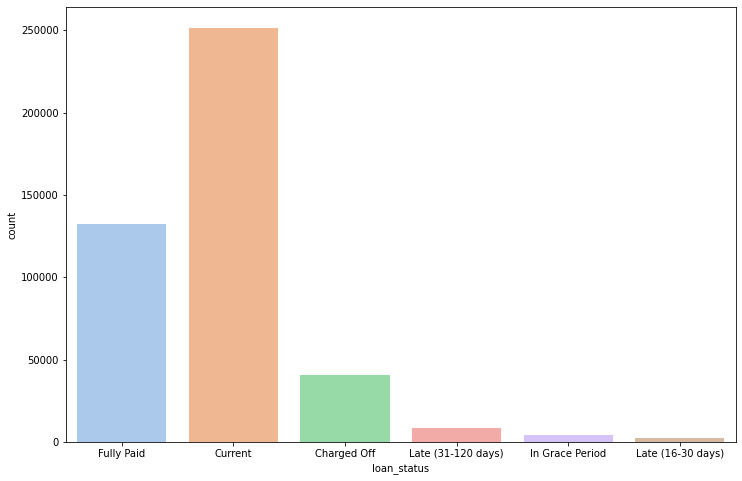

In [14]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x="loan_status")
df["loan_status"].value_counts(dropna=False)

Our objective is to classify loans as a binary "good" vs "bad", so let's merge/convert some of these classes. We'll consider any loan that's in good standing (Fully Paid, Current, In Grace Period) as "good" & any that's in poor standing (Charged Off, Late) as "bad". Since we'll focus on finding the "bad" loans, we'll map that to 1 (the positive class) & the "good" to 0 (the negative class).

0    387623
1     51368
Name: loan_status, dtype: int64

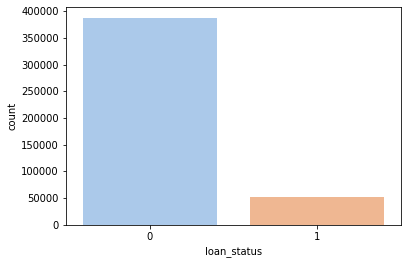

In [15]:
df["loan_status"] = df["loan_status"] \
    .isin(["Charged Off", "Late (16-30 days)", "Late (31-120 days)"]) \
    .astype("int")

sns.countplot(data=df, x="loan_status")
df["loan_status"].value_counts(dropna=False)

In [16]:
df["loan_status"].value_counts(normalize=True, dropna=False)

0    0.882986
1    0.117014
Name: loan_status, dtype: float64

There is quite a mismatch between our classes. This imbalance could cause problems for our model, so we might want to start thinking about up/undersampling to even out the classes.

## 4) Dropping extraneous features

We don't want our model to have access to information that a potential investor wouldn't because then our findings lose translatability, so we'll drop some information at this point. I'm not an investor, so we'll have to rely on my best judgement to make the call on whether a prospective investor would have access to certain features or not. From reading the data dictionary, it seems that `funded_amnt`, which would be the amount committed to the loan once it's been decided to be funded, is the only feature that we'll need to cut.

In [17]:
to_drop = ["funded_amnt"]

df.drop(columns=to_drop, axis=1, inplace=True)

## 5) Preprocessing

Let"s inspect the categorical features & make sure that their types are optimal.

In [18]:
df.select_dtypes("object").sample(n=5)

,term,int_rate,emp_title,emp_length,home_ownership,purpose,zip_code,addr_state,earliest_cr_line,revol_util,application_type,sec_app_earliest_cr_line,quarter
2314,36 months,7.35%,Driver,3 years,MORTGAGE,debt_consolidation,333xx,FL,Nov-03,22.40%,Individual,NaN,2017Q3
23667,60 months,11.99%,Professor and Instructional Mentor,10+ years,MORTGAGE,debt_consolidation,245xx,VA,Jul-89,34%,Individual,NaN,2016Q1
19435,36 months,7.39%,Supervisor,10+ years,MORTGAGE,major_purchase,945xx,CA,Jun-77,36.80%,Individual,NaN,2016Q2
19566,60 months,18.99%,NaN,NaN,RENT,credit_card,225xx,VA,Apr-03,57%,Individual,NaN,2017Q1
2957,36 months,17.27%,Warehouse,10+ years,RENT,debt_consolidation,442xx,OH,Oct-03,70.90%,Individual,NaN,2016Q2


A lot of these could be changed into more amenable forms. We'll also need to apply some basic string processing to each to ensure that there's no white space or differences in capitalization.

*Post-analysis thought: The basic string processing probably could've been handled in a loop that went over all of these features iteratively instead of manual adjustment on a per feature basis. I had already almost finished each individually by the time I had thought of this, so I forged ahead.*

### 5.1) `zip_code`

Let's focus on the `zip_code` feature. Right now, it's in a poor format for modeling because zip codes shouldn't be treated as numeric, but encoding them later on would cause massive inflation of the feature space. Therefore, let's try to extract the information contained in `zip_code` & use it to create more amenable features. We already have the state information from `addr_state` (conveniently, this feature also tells us that all observations are from the United States), but we could turn the zip codes into *approximate* latitudes & longitudes. I have to stress that these will only be approximate because we've only been given the first 3 digits of each zip code, so we'll invariably have multiple matches per row (this is also why we can't glean extra information such as County). When we encounter multiple matches, we'll simply take the first match during the merge.

In [19]:
df["zip_code"].sample(n=5)

15818    549xx
22791    330xx
2298     300xx
15406    337xx
26413    762xx
Name: zip_code, dtype: object

In [20]:
df["zip_code"].describe()

count     438991
unique       908
top        750xx
freq        4620
Name: zip_code, dtype: object

In [21]:
census_zips = pd.read_csv(r".\resources\US20Codes20201320Data.txt") # Source: https://gist.github.com/erichurst/7882666

census_zips.rename(columns={"ZIP": "zip_code", "LAT": "lat", "LNG": "lon"}, inplace=True)

census_zips["zip_code"] = census_zips["zip_code"] \
    .astype("object") \
    .apply(lambda x: str(x)[0:3]) \
    .astype("int")

In [22]:
census_zips["zip_code"] \
    .duplicated() \
    .value_counts()

True     32291
False      853
Name: zip_code, dtype: int64

We have to drop duplicate zip codes here or our dataset will explode due to multiple matching.

In [23]:
census_zips.drop_duplicates(subset=["zip_code"], inplace=True)

In [24]:
df["zip_code"] = df["zip_code"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x)[0:3]) \
    .astype("int")

In [25]:
df.iloc[np.setdiff1d(df["zip_code"].unique(), census_zips["zip_code"].unique())]["zip_code"].sample(n=5)

46    871
7     208
81    221
72    707
52    220
Name: zip_code, dtype: int32

In [26]:
df.iloc[np.setdiff1d(df["zip_code"].unique(), census_zips["zip_code"].unique())]["zip_code"].describe()

count    101.000000
mean     524.623762
std      303.811088
min       21.000000
25%      293.000000
50%      482.000000
75%      790.000000
max      983.000000
Name: zip_code, dtype: float64

It looks like our zip code resource had incomplete coverage of US postal codes. A merge between this & our dataset will cause some `NaN` values to be generated, but this should only affect 101 rows.

In [27]:
df = df.merge(census_zips, "left", on="zip_code")

In [28]:
df.drop(["zip_code"], axis=1, inplace=True)

In [29]:
df[["lat", "lon"]].sample(n=5)

,lat,lon
123509,32.759104,-97.329756
285783,43.238549,-71.555988
232607,34.037340,-119.800786
11867,18.318884,-66.119190
90063,27.763831,-82.276174


In [30]:
df[["lat", "lon"]].describe()

,lat,lon
count,399137.000000,399137.000000
mean,35.597969,-79.778897
std,9.762139,17.248290
min,17.709936,-159.856068
25%,30.758721,-82.632806
50%,40.417778,-72.659997
75%,42.411887,-70.172185
max,67.094545,-64.682933


*Post-analysis thought: Let's plot these for fun.*

In [432]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

<AxesSubplot:>

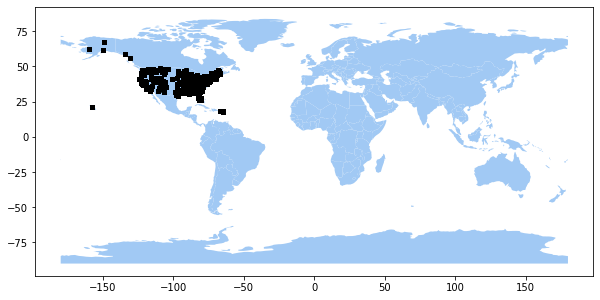

In [434]:
geo = [Point(xy) for xy in zip(df["lon"], df["lat"])]
gdf = GeoDataFrame(df, geometry=geo)

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
gdf.plot(
    ax=world.plot(figsize=(10, 6)),
    marker="o",
    color="black",
    markersize=15
)

Interestingly, it looks like we had a match down in Puerto Rico, which may or may not be "real" because we only considered the first match.

### 5.2) Dates

`quarter`, `earliest_cr_line`, & `sec_app_earliest_cr_line` all represent `datetime` information.

In [31]:
df[["quarter", "earliest_cr_line", "sec_app_earliest_cr_line"]].sample(n=5)

,quarter,earliest_cr_line,sec_app_earliest_cr_line
373528,2017Q3,Aug-96,NaN
220355,2017Q1,Aug-01,NaN
378242,2017Q3,Aug-06,NaN
159918,2016Q3,Nov-94,NaN
180273,2016Q4,Nov-00,NaN


In [32]:
df[["quarter", "earliest_cr_line", "sec_app_earliest_cr_line"]].describe()

,quarter,earliest_cr_line,sec_app_earliest_cr_line
count,438991,438991,19671
unique,8,680,559
top,2016Q1,Sep-05,Aug-06
freq,66943,3353,191


It looks like we really only get months & years, so let's break these features apart into a couple of numerical features each.

### 5.2.1) `quarter`

In [33]:
df["quarter"].sample(n=5)

408948    2017Q4
342493    2017Q3
233099    2017Q1
73892     2016Q2
44161     2016Q1
Name: quarter, dtype: object

In [34]:
df["quarter"].describe()

count     438991
unique         8
top       2016Q1
freq       66943
Name: quarter, dtype: object

In [35]:
df["app_yr"] = df["quarter"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x)[0:4]).astype("int")

df["app_qr"] = df["quarter"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x)[-2:])

In [36]:
df[["app_yr", "app_qr"]].sample(n=5)

,app_yr,app_qr
140867,2016,Q3
179890,2016,Q4
343461,2017,Q3
8696,2016,Q1
369864,2017,Q3


In [37]:
df[["app_yr", "app_qr"]].describe()

,app_yr
count,438991.000000
mean,2016.505222
std,0.499973
min,2016.000000
25%,2016.000000
50%,2017.000000
75%,2017.000000
max,2017.000000


In [38]:
df.drop(["quarter"], axis=1, inplace=True)

### 5.2.2) `earliest_cr_line`

In [39]:
df["earliest_cr_line"].sample(n=5)

136420    Nov-72
328724    May-14
267282    Mar-06
52576     Feb-09
280356    Sep-95
Name: earliest_cr_line, dtype: object

In [40]:
df["earliest_cr_line"].describe()

count     438991
unique       680
top       Sep-05
freq        3353
Name: earliest_cr_line, dtype: object

In [41]:
df["earliest_cr_line"] = df["earliest_cr_line"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x).upper())

df["earliest_cr_line_yr"] = df["earliest_cr_line"] \
    .apply(lambda x: str(x)[-2:]) \
    .astype("int") \
    .apply(lambda x: x + 2000 if x <= 14 else x + 1900)

df["earliest_cr_line_mo"] = df["earliest_cr_line"] \
    .apply(lambda x: str(x)[0:3]) \
    .replace({
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12
})

In [42]:
df[["earliest_cr_line_yr", "earliest_cr_line_mo"]].sample(n=5)

,earliest_cr_line_yr,earliest_cr_line_mo
391545,2002,9
353951,2001,2
188016,1995,1
271932,2003,3
354521,2005,12


In [43]:
df[["earliest_cr_line_yr", "earliest_cr_line_mo"]].describe()

,earliest_cr_line_yr,earliest_cr_line_mo
count,438991.000000,438991.000000
mean,1999.874241,6.734004
std,7.793951,3.368598
min,1933.000000,1.000000
25%,1996.000000,4.000000
50%,2001.000000,7.000000
75%,2005.000000,10.000000
max,2014.000000,12.000000


In [44]:
df.drop(["earliest_cr_line"], axis=1, inplace=True)

### 5.2.3) `sec_app_earliest_cr_line`

In [45]:
df["sec_app_earliest_cr_line"].sample(n=5)

52653     NaN
30521     NaN
22944     NaN
352352    NaN
301755    NaN
Name: sec_app_earliest_cr_line, dtype: object

In [46]:
df["sec_app_earliest_cr_line"].describe()

count      19671
unique       559
top       Aug-06
freq         191
Name: sec_app_earliest_cr_line, dtype: object

This feature contains `NaN`s, which will interfere with our manipulations. We'll elect to fill them with zeros, which should be an apt representation for the lack of information from a co-signer on the loan.

In [47]:
df["sec_app_earliest_cr_line"] = df["sec_app_earliest_cr_line"] \
    .fillna(value="000-00") \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x).upper())

df["sec_app_earliest_cr_line_yr"] = df["sec_app_earliest_cr_line"] \
    .apply(lambda x: str(x)[-2:]) \
    .astype("int") \
    .apply(lambda x: x + 1900 if x > 14 else x) \
    .apply(lambda x: x + 2000 if x <= 14 and x > 0 else x)

df["sec_app_earliest_cr_line_mo"] = df["sec_app_earliest_cr_line"] \
    .apply(lambda x: str(x)[0:3]) \
    .replace({
        "000": 0,
        "JAN": 1,
        "FEB": 2,
        "MAR": 3,
        "APR": 4,
        "MAY": 5,
        "JUN": 6,
        "JUL": 7,
        "AUG": 8,
        "SEP": 9,
        "OCT": 10,
        "NOV": 11,
        "DEC": 12
})

In [48]:
df[["sec_app_earliest_cr_line_yr", "sec_app_earliest_cr_line_mo"]].sample(n=5)

,sec_app_earliest_cr_line_yr,sec_app_earliest_cr_line_mo
397065,0,0
378397,0,0
115836,0,0
340112,0,0
270729,0,0


In [49]:
df[["sec_app_earliest_cr_line_yr", "sec_app_earliest_cr_line_mo"]].describe()

,sec_app_earliest_cr_line_yr,sec_app_earliest_cr_line_mo
count,438991.000000,438991.000000
mean,85.580073,0.303860
std,404.782649,1.571181
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,2014.000000,12.000000


In [50]:
df.drop(["sec_app_earliest_cr_line"], axis=1, inplace=True)

### 5.3) `emp_length`

`emp_length` is currently encoded as a categorical feature, but it would make more sense as a numeric, so we'll change it into a `float` here. We"ll use 0 & 11 for "< 1" & "10+", respectively.

In [51]:
df["emp_length"].sample(n=5)

212454      9 years
281917          NaN
385245    10+ years
193725      2 years
348703      3 years
Name: emp_length, dtype: object

In [52]:
df["emp_length"].describe()

count        408978
unique           11
top       10+ years
freq         148471
Name: emp_length, dtype: object

In [53]:
df["emp_length"] = df["emp_length"].replace({
    "< 1 year": "0 years",
    "10+ years": "11 years"
})

df["emp_length"] = df["emp_length"].str.extract("(\d+)").astype("float")

In [54]:
df["emp_length"].sample(n=5)

43993     11.0
164029    11.0
292823     9.0
196864    11.0
261278    11.0
Name: emp_length, dtype: float64

In [55]:
df["emp_length"].describe()

count    408978.000000
mean          6.295987
std           4.159363
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          11.000000
Name: emp_length, dtype: float64

### 5.4) `term`

In [56]:
df["term"].sample(n=5)

143134     36 months
372286     36 months
343757     36 months
52323      36 months
38963      36 months
Name: term, dtype: object

In [57]:
df["term"].describe()

count         438991
unique             2
top        36 months
freq          322236
Name: term, dtype: object

In [58]:
df["term"] = df["term"].replace({
    "36 months": "36",
    "60 Months": "60"
})

df["term"] = df["term"].str.extract("(\d+)").astype("int")

In [59]:
df["term"].sample(n=5)

299974    36
242154    36
327331    36
438058    36
375552    36
Name: term, dtype: int32

In [60]:
df["term"].describe()

count    438991.000000
mean         42.383092
std          10.604273
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: term, dtype: float64

### 5.5) `emp_title`

In [61]:
df["emp_title"].sample(n=5)

146169       technician
389752           Server
136428    Surgical tech
432449               VP
195818              NaN
Name: emp_title, dtype: object

In [62]:
df["emp_title"].describe()

count      408624
unique     120032
top       Teacher
freq         8392
Name: emp_title, dtype: object

In [63]:
df["emp_title"] = df["emp_title"] \
    .apply(lambda x: str(x).upper()) \
    .apply(lambda x: str(x).strip())

In [64]:
df["emp_title"].sample(n=5)

242368                            ACCOUNTANT
282011    STAFFING AND OPERATIONS SUPERVISOR
39999      TECHNICAL AND ENGINEERING MANAGER
69254       GOVERNMENT ENROLLMENT SPECIALIST
357505                                    RN
Name: emp_title, dtype: object

In [65]:
df["emp_title"].describe()

count     438991
unique     93860
top          NAN
freq       30367
Name: emp_title, dtype: object

*Post-analysis thought: I should've caught this earlier, but there are actual `NaN`s and the string "NaN" in this data. I probably should've replaced the string version with the actual thing, but we ended up dropping this feature later on anyways & it probably wouldn't have changed anything.*

### 5.6) Percentages (`revol_util` & `int_rate`)

In [66]:
df[["revol_util", "int_rate"]].sample(n=5)

,revol_util,int_rate
184956,91%,11.49%
273542,39.50%,7.97%
287765,86.80%,20.00%
378547,7.10%,7.97%
340145,65.30%,10.42%


In [67]:
df[["revol_util", "int_rate"]].describe()

,revol_util,int_rate
count,438632,438991
unique,1163,169
top,0%,5.32%
freq,2235,17480


In [68]:
df["revol_util"] = df["revol_util"].str.rstrip("%").astype("float") / 100.0
df["int_rate"] = df["int_rate"].str.rstrip("%").astype("float") / 100.0

In [69]:
df[["revol_util", "int_rate"]].sample(n=5)

,revol_util,int_rate
383325,0.359,0.1408
244250,0.413,0.0824
337986,0.353,0.1408
295827,0.700,0.0824
233464,0.498,0.1274


In [70]:
df[["revol_util", "int_rate"]].describe()

,revol_util,int_rate
count,438632.000000,438991.000000
mean,0.492409,0.131441
std,0.245152,0.050626
min,0.000000,0.053200
25%,0.305000,0.094900
50%,0.488000,0.126200
75%,0.678000,0.155900
max,1.720000,0.309900


### 5.7) `addr_state`

In [71]:
df["addr_state"] = df["addr_state"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x).upper())

### 5.8) `home_ownership`

In [72]:
df["home_ownership"] = df["home_ownership"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x).upper())

### 5.9) `application_type`

In [73]:
df["application_type"] = df["application_type"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x).upper())

### 5.10) `purpose`

In [74]:
df["purpose"] = df["purpose"] \
    .apply(lambda x: str(x).strip()) \
    .apply(lambda x: str(x).upper())

In [75]:
df.select_dtypes("object").sample(n=5)

,emp_title,home_ownership,purpose,addr_state,application_type,app_qr
353854,HOUSEKEEPING,RENT,OTHER,IL,INDIVIDUAL,Q3
131266,CVT,MORTGAGE,HOME_IMPROVEMENT,FL,INDIVIDUAL,Q3
94898,VP OPERATIONS,RENT,CREDIT_CARD,FL,INDIVIDUAL,Q2
267824,TRANSACTION COORDINATOR,RENT,DEBT_CONSOLIDATION,VA,INDIVIDUAL,Q2
182869,LPN,MORTGAGE,DEBT_CONSOLIDATION,VA,INDIVIDUAL,Q4


### 5.11) Missing data

In [76]:
nan_df = df.isna().mean()
nan_df = nan_df[nan_df != 0].sort_values(ascending=False)
nan_df

revol_bal_joint                   0.955193
sec_app_inq_last_6mths            0.955190
sec_app_fico_range_high           0.955190
dti_joint                         0.941211
annual_inc_joint                  0.941208
mths_since_recent_bc_dlq          0.756205
mths_since_recent_revol_delinq    0.650551
mths_since_last_delinq            0.486743
il_util                           0.135686
lon                               0.090785
lat                               0.090785
emp_length                        0.068368
bc_util                           0.012276
percent_bc_gt_75                  0.011884
bc_open_to_buy                    0.011825
mths_since_recent_bc              0.011167
revol_util                        0.000818
dti                               0.000649
all_util                          0.000169
open_rv_24m                       0.000062
open_il_24m                       0.000062
open_act_il                       0.000062
inq_last_12m                      0.000062
dtype: floa

Text(0, 0.5, 'Count')

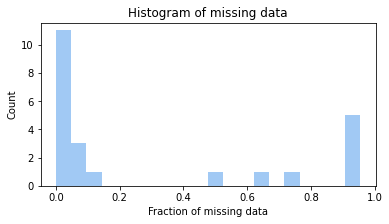

In [77]:
plt.figure(figsize=(6, 3))
nan_df.plot.hist(bins=20)
plt.title("Histogram of missing data")
plt.xlabel("Fraction of missing data")
plt.ylabel("Count")

Some of the missing values shouldn't be too difficult to fill in. For example, a missing entry for `emp_title` could just be that the applicant forgot to fill it in, so we can input an empty string in place of a `NaN`. For the numeric columns, we'll need to think a little bit more. Something like `mths_since_last_delinq` is probably missing because the applicant hasn't had another deliquency that would require a new record to be made. Therefore, we should fill in these types of values with the maximum of the column.

In [78]:
fill_max = [
    "bc_open_to_buy",
    "mths_since_last_delinq",
    "mths_since_recent_bc",
    "mths_since_recent_bc_dlq",
    "mths_since_recent_revol_delinq",
    "pct_tl_nvr_dlq"
]

In [79]:
df["emp_title"] = df["emp_title"].fillna("")
df[fill_max] = df[fill_max].fillna(df[fill_max].max())

In [80]:
nan_df = df.isna().mean()
nan_df = nan_df[nan_df != 0].sort_values(ascending=False)
nan_df

revol_bal_joint            0.955193
sec_app_inq_last_6mths     0.955190
sec_app_fico_range_high    0.955190
dti_joint                  0.941211
annual_inc_joint           0.941208
il_util                    0.135686
lon                        0.090785
lat                        0.090785
emp_length                 0.068368
bc_util                    0.012276
percent_bc_gt_75           0.011884
revol_util                 0.000818
dti                        0.000649
all_util                   0.000169
inq_last_12m               0.000062
open_rv_24m                0.000062
open_il_24m                0.000062
open_act_il                0.000062
dtype: float64

Text(0, 0.5, 'Count')

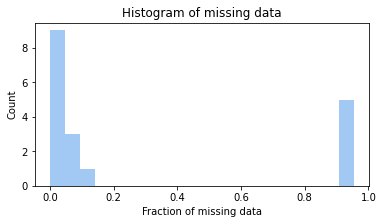

In [81]:
plt.figure(figsize=(6, 3))
nan_df.plot.hist(bins=20)
plt.title("Histogram of missing data")
plt.xlabel("Fraction of missing data")
plt.ylabel("Count")

There are still some features that are missing large swaths of data. We'll remove any that are missing more than 30% of their values. Imputation, which we'll rely on later, wouldn't be as reliable for features that have such a high degree of missing information.

In [82]:
to_drop = sorted(list(nan_df[nan_df > 0.3].index))
print(to_drop)

['annual_inc_joint', 'dti_joint', 'revol_bal_joint', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths']


In [83]:
len(to_drop)

5

All of the features that we're dropping has to do with joint applications. They represent a very small minority of loan applications within this dataset, but it probably could reduce the predictive power of our model when it comes to joint applications since we'd have less information about them.

In [84]:
df.drop(columns=to_drop, axis=1, inplace=True)

In [85]:
df.shape

(438991, 54)

In [86]:
nan_df = df.isna().mean()
nan_df = nan_df[nan_df != 0].sort_values(ascending=False)
nan_df

il_util             0.135686
lat                 0.090785
lon                 0.090785
emp_length          0.068368
bc_util             0.012276
percent_bc_gt_75    0.011884
revol_util          0.000818
dti                 0.000649
all_util            0.000169
open_act_il         0.000062
open_il_24m         0.000062
open_rv_24m         0.000062
inq_last_12m        0.000062
dtype: float64

Text(0, 0.5, 'Count')

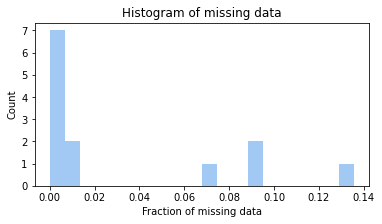

In [87]:
plt.figure(figsize=(6, 3))
nan_df.plot.hist(bins=20)
plt.title("Histogram of missing data")
plt.xlabel("Fraction of missing data")
plt.ylabel("Count")

## 6) Exploration

In [88]:
def plot_feat(feat, cont):
    """
    Visualize distributions of features with & without grouping by the target. Continuous depictions include statistics describing the distribtion of the data.
    - feat: Feature that is being visualized
    - cont: Whether the feature is continuous or not
        - stats:
            - skewness: A measure of how skewed the data is. A normal distribution would have a skewness of 0
            - kurtosis: A measure of tailedness. Thinner distributions would have lower values & fatter distributions would have higher values
            - Shapiro-Wilk: A statistical test that measures how well the data fits a normal distribution
            - Pearson: A measure of linear correlation
    """
    
    df_cp = df.copy()
    df_cp["loan_status"] = df_cp["loan_status"].replace({0: "Fully Paid", 1: "Charged Off"})

    if cont:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 4))
        fig.suptitle("QQ-plot & Distribution of " + feat)
        sm.qqplot(df_cp[feat].dropna(axis=0), scp.t, distargs=(4, ), fit=True, line="45", ax=ax[0], )
        sns.distplot(df_cp[feat], kde=True, hist=True, fit=scp.norm, ax=ax[1])
        sns.boxplot(data=df_cp, x=feat, y="loan_status")

        shap_t, shap_p = scp.shapiro(df_cp[feat])

        pc = df[feat].corr(df["loan_status"])

        print(f"Feature: {feat}")
        print(f"Skewness: {abs(df_cp[feat]).skew():.4f}")
        print(f"Kurtosis: {abs(df_cp[feat]).kurt():.4f}")
        print(f"Shapiro stat, p: {shap_t:.4f}, {shap_p:.4f}")
        print(f"Pearson corr w/target: {pc:.4f}")
        print()

    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 4))
        sns.countplot(df_cp[feat], order=sorted(df_cp[feat].unique()), ax=ax[0])
        co_rate = df_cp.groupby(feat)["loan_status"].value_counts(normalize=True).loc[:, "Charged Off"]
        sns.barplot(x=co_rate.index, y=co_rate.values, ax=ax[1])
        ax[1].set_ylabel("Charge off rate")

    plt.tight_layout()

I also include a Mann-Whitney U-test (aka Wilcoxon Rank Sum test) to have some measure, other than my own eyes, to determine if the distributions of a given feature are different when split by the target. The U-test is a non-parametric test (i.e., it doesn't make very many assumptions about the data) that will compare the distributions of the ranks of each array. **Spoiler alert:** It detects a lot of differences between the Fully Paid & Charged off sets of each feature below.

I tried to wrap the Mann-Whitney U-test functionality into the function above, but it didn't want to work that way.

In [89]:
df.nunique().sort_values(ascending=False)

id                                438991
total_bal_ex_mort                 132771
emp_title                          93860
revol_bal                          61561
bc_open_to_buy                     56852
installment                        44023
annual_inc                         28079
total_rev_hi_lim                   11275
dti                                 6986
total_bc_limit                      5562
bc_util                             1269
revol_util                          1163
lon                                  807
lat                                  807
pct_tl_nvr_dlq                       600
mths_since_recent_bc                 437
il_util                              242
percent_bc_gt_75                     207
all_util                             175
int_rate                             169
mths_since_recent_revol_delinq       149
mths_since_recent_bc_dlq             148
mths_since_last_delinq               147
total_acc                            126
num_rev_accts   

We'll go through each of these features one at a time. Also note that whenever I log transform a feature, I'm using the `np.log1p` instead of `np.log10` in case there are any `NaN` values in the feature. The former simply addes a 1 to the value prior to taking the logarithm, which gets around any errors we'd get by trying to perform `np.log10(0)`. This is a common approach in the biological field to transform zero-inflated data (e.g., single-cell sequencing data).

Also, recall what I said when we were initially importing the data. I am neither a banker nor a lender, so my interpretation of some of these more esoteric features will likely be surface-level.

### 6.1) `id`

Data Dictionary: "A unique LC assigned ID for the loan listing."

In [90]:
df["id"].dtype

dtype('int64')

It would make more sense for ID numbers to be categorical.

In [91]:
df["id"] = df["id"].astype("object")

In [92]:
df["id"].sample(n=5)

285784    110686127
259131     97739934
195644     91813863
332399    116923905
233083     98126088
Name: id, dtype: object

In [93]:
df["id"].describe()

count       438991
unique      438991
top       73688651
freq             1
Name: id, dtype: int64

The `id` column is completely unique & thus wouldn't be useful for modeling. We'll discard it.

In [94]:
df.drop(["id"], axis=1, inplace=True)

### 6.2) `total_bal_ex_mort`

Data Dictionary: "Total credit balance excluding mortgage"

In [95]:
df["total_bal_ex_mort"].dtype

dtype('int64')

In [96]:
df["total_bal_ex_mort"].sample(n=5)

191511    216334
59805      28627
351845     55143
204429      4878
218815     33812
Name: total_bal_ex_mort, dtype: int64

In [97]:
df["total_bal_ex_mort"].describe()

count    4.389910e+05
mean     5.235281e+04
std      5.106754e+04
min      0.000000e+00
25%      2.138700e+04
50%      3.874100e+04
75%      6.611400e+04
max      3.408095e+06
Name: total_bal_ex_mort, dtype: float64

In [98]:
df.groupby("loan_status")["total_bal_ex_mort"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,52459.526855,51570.560656,0.0,21269.00,38685.0,66230.0,3408095.0
1,51368.0,51547.501304,47091.531105,0.0,22273.75,39190.5,65268.5,717987.0


In [99]:
df_class_0 = df.loc[df["loan_status"] == 0]["total_bal_ex_mort"]
df_class_1 = df.loc[df["loan_status"] == 1]["total_bal_ex_mort"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9877325030.0000
U-test p-value: 0.0037


The Fully Paid group has higher max total credit balance, but the rest of the summary statistics appear similar. These high data points are likely just a few outliers.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: total_bal_ex_mort
Skewness: 4.3268
Kurtosis: 83.2816
Shapiro stat, p: 0.7221, 0.0000
Pearson corr w/target: -0.0057



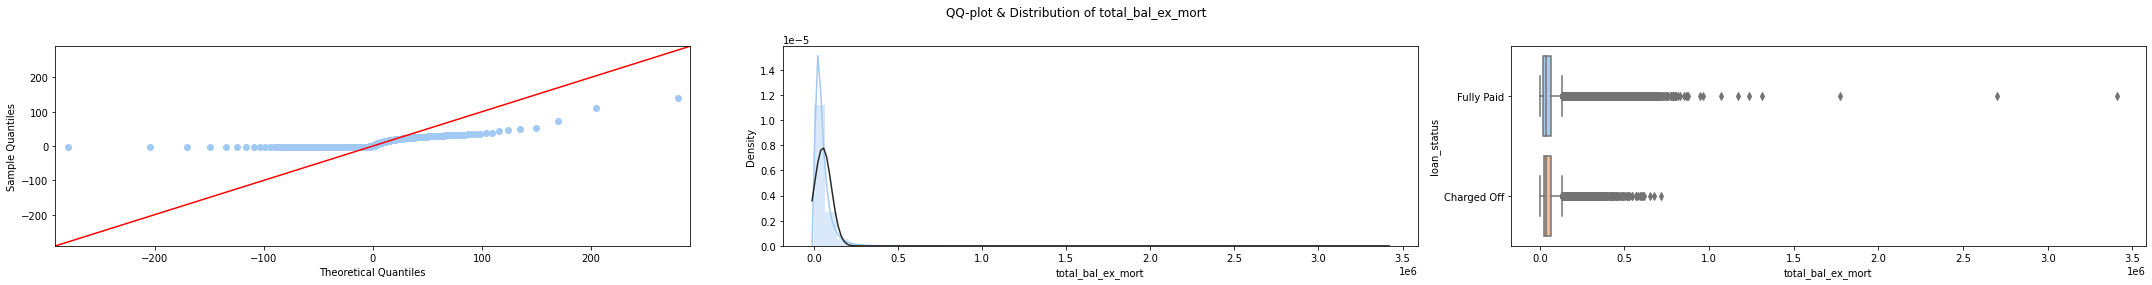

In [100]:
plot_feat("total_bal_ex_mort", cont=True)

The distribution is very skewed & the range of the scales is quite large. Therefore, we'll log transform the data.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: log1p_total_bal_ex_mort
Skewness: -1.4713
Kurtosis: 9.4680
Shapiro stat, p: 0.9337, 0.0000
Pearson corr w/target: 0.0054



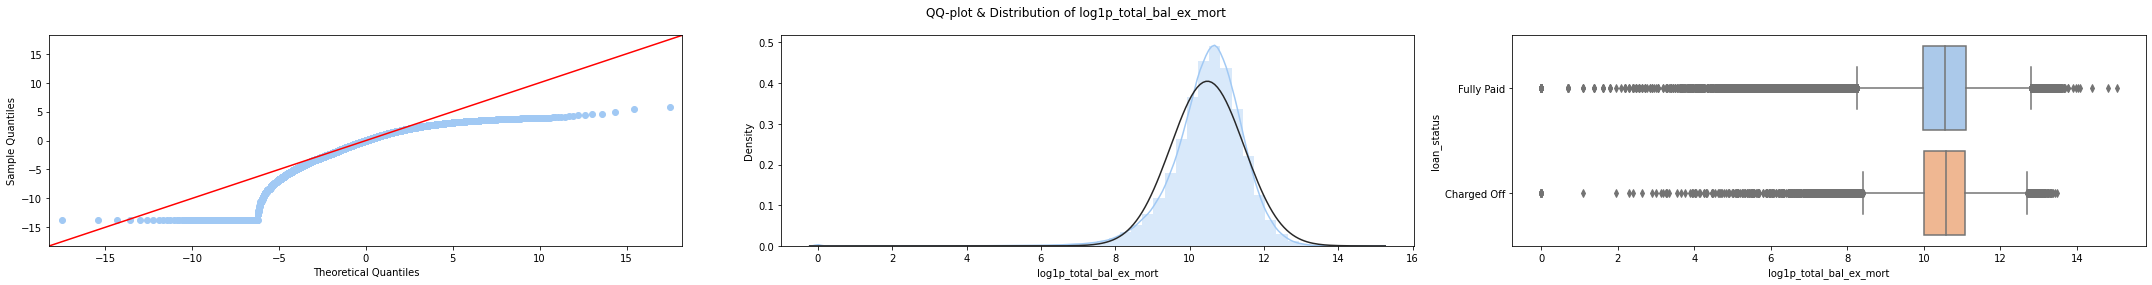

In [101]:
df["log1p_total_bal_ex_mort"] = np.log1p(df["total_bal_ex_mort"])
plot_feat("log1p_total_bal_ex_mort", cont=True)

In [102]:
df.drop(["total_bal_ex_mort"], axis=1, inplace=True)

### 6.3 `emp_title`

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [103]:
df["emp_title"].dtype

dtype('O')

In [104]:
df["emp_title"].sample(n=5)

413128             GENERAL MANAGER
118544             CHILDREN'S LEAD
76298     ADMINISTRATIVE ASSISTANT
146169                  TECHNICIAN
99018                      TEACHER
Name: emp_title, dtype: object

In [105]:
df["emp_title"].describe()

count     438991
unique     93860
top          NAN
freq       30367
Name: emp_title, dtype: object

The `emp_title` column has too many unique values & thus wouldn't be useful for modeling. We'll discard it.

In [106]:
df.drop(["emp_title"], axis=1, inplace=True)

### 6.4) `revol_bal`

Data Dictionary: "Total credit revolving balance"

In [107]:
df["revol_bal"].dtype

dtype('int64')

In [108]:
df["revol_bal"].sample(n=5)

122457    19380
256717     4251
387716     9409
52871     28390
221541     4079
Name: revol_bal, dtype: int64

In [109]:
df["revol_bal"].describe()

count    4.389910e+05
mean     1.663897e+04
std      2.383450e+04
min      0.000000e+00
25%      5.815000e+03
50%      1.104000e+04
75%      1.985000e+04
max      2.559552e+06
Name: revol_bal, dtype: float64

In [110]:
df.groupby("loan_status")["revol_bal"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,16817.495056,24348.770320,0.0,5827.0,11090.0,20016.0,2559552.0
1,51368.0,15291.828376,19469.284096,0.0,5721.0,10694.0,18662.0,666627.0


In [111]:
df_class_0 = df.loc[df["loan_status"] == 0]["revol_bal"]
df_class_1 = df.loc[df["loan_status"] == 1]["revol_bal"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10231891603.0000
U-test p-value: 0.0000


The Fully Paid group tends to carry a higher revolving balance.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: revol_bal
Skewness: 12.5574
Kurtosis: 550.5740
Shapiro stat, p: 0.4722, 0.0000
Pearson corr w/target: -0.0206



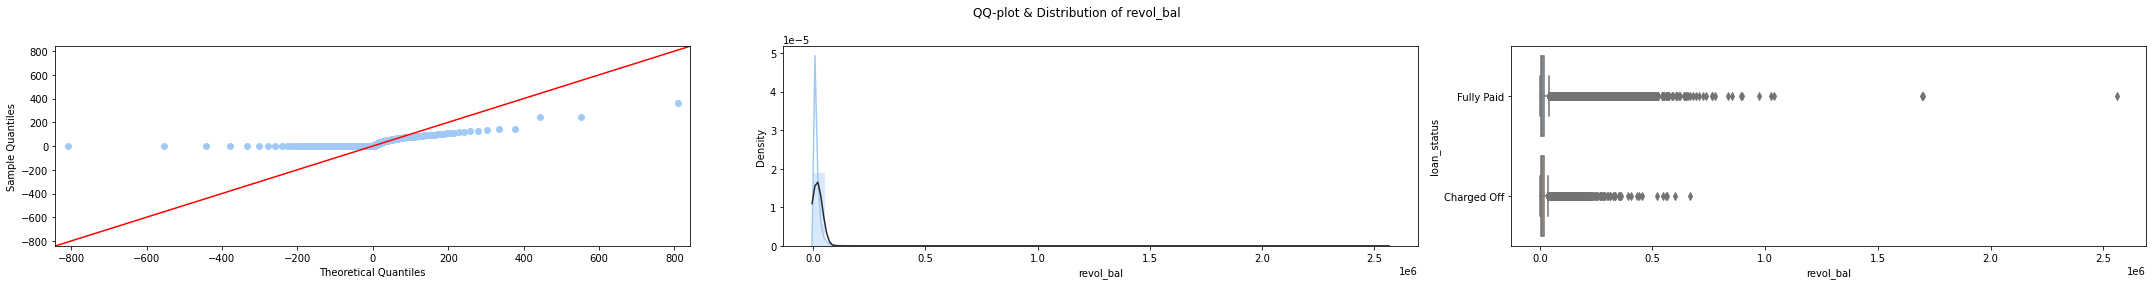

In [112]:
plot_feat("revol_bal", cont=True)

The distribution is very skewed & the range of the scales is quite large. Therefore, we'll log transform the data.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: log1p_revol_bal
Skewness: -2.5120
Kurtosis: 15.0745
Shapiro stat, p: 0.8380, 0.0000
Pearson corr w/target: -0.0122



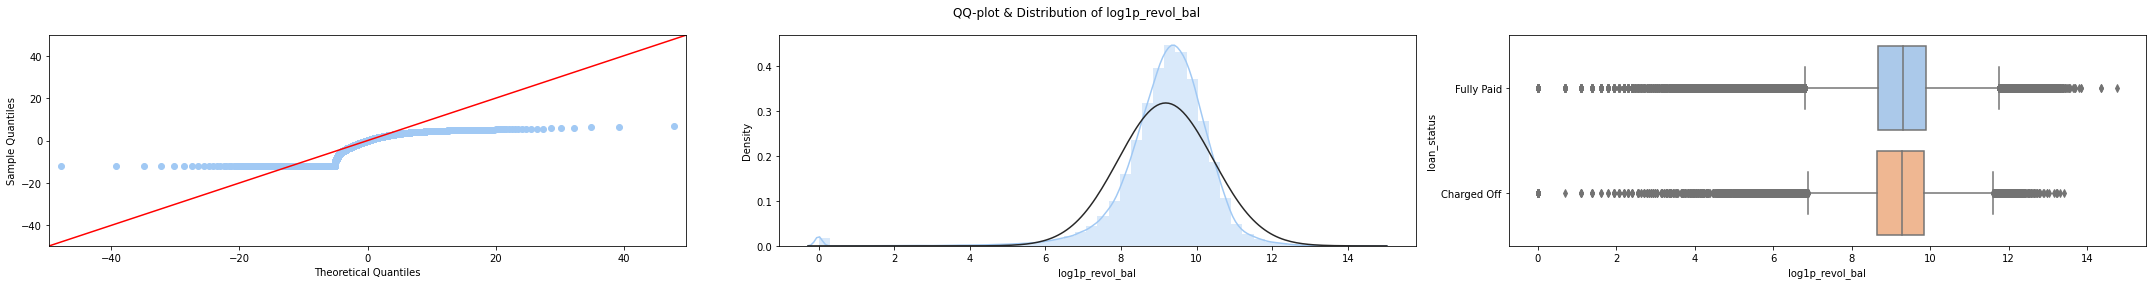

In [113]:
df["log1p_revol_bal"] = np.log1p(df["revol_bal"])
plot_feat("log1p_revol_bal", cont=True)

In [114]:
df.drop(["revol_bal"], axis=1, inplace=True)

### 6.5) `bc_open_to_buy`

Data Dictionary: "Total open to buy on revolving bankcards"

In [115]:
df["bc_open_to_buy"].dtype

dtype('float64')

It would make more sense for this to be an int.

In [116]:
df["bc_open_to_buy"] = df["bc_open_to_buy"].astype("int")

In [117]:
df["bc_open_to_buy"].sample(n=5)

53432     15024
197173     2138
97035       130
335008    10753
37556     11455
Name: bc_open_to_buy, dtype: int32

In [118]:
df["bc_open_to_buy"].describe()

count    438991.000000
mean      19884.168067
std       77402.087065
min           0.000000
25%        1938.000000
50%        5885.000000
75%       15013.000000
max      711140.000000
Name: bc_open_to_buy, dtype: float64

In [119]:
df.groupby("loan_status")["bc_open_to_buy"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,20257.801686,77311.465831,0.0,2014.0,6142.0,15629.00,711140.0
1,51368.0,17064.728255,78025.611821,0.0,1432.0,4350.0,10807.25,711140.0


In [120]:
df_class_0 = df.loc[df["loan_status"] == 0]["bc_open_to_buy"]
df_class_1 = df.loc[df["loan_status"] == 1]["bc_open_to_buy"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 11250689941.0000
U-test p-value: 0.0000


The Fully Paid group tends to have higher values of this feature. It looks like there's a single member of the Charged Off group that matches the max value of the opposing group.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: bc_open_to_buy
Skewness: 8.4444
Kurtosis: 72.2826
Shapiro stat, p: 0.1908, 0.0000
Pearson corr w/target: -0.0133



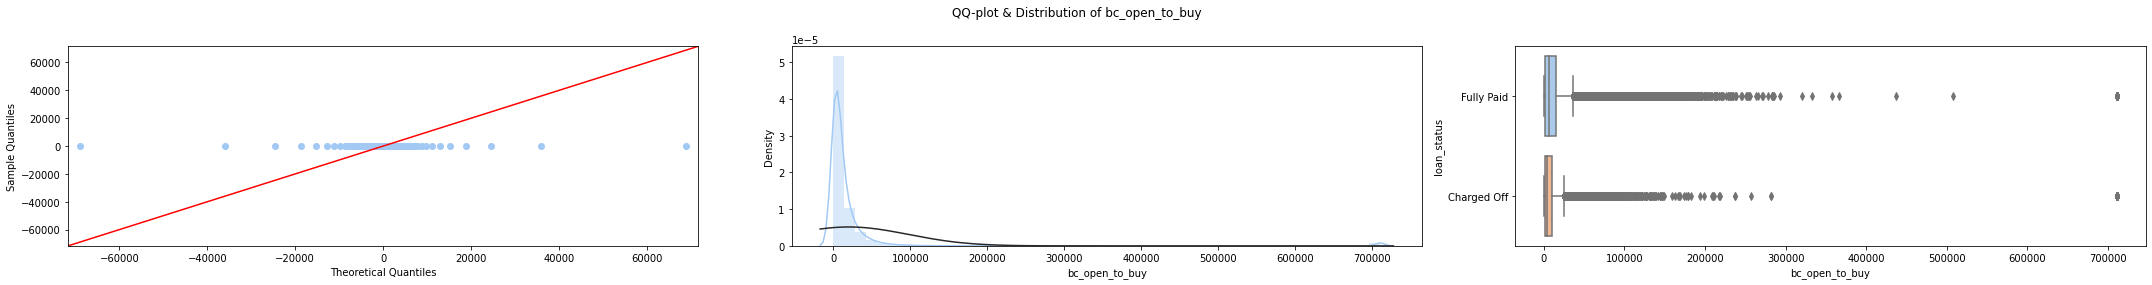

In [121]:
plot_feat("bc_open_to_buy", cont=True)

The distribution is very skewed & the range of the scales is quite large. Therefore, we'll log transform the data.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: log1p_bc_open_to_buy
Skewness: -1.2300
Kurtosis: 4.0360
Shapiro stat, p: 0.9196, 0.0000
Pearson corr w/target: -0.0627



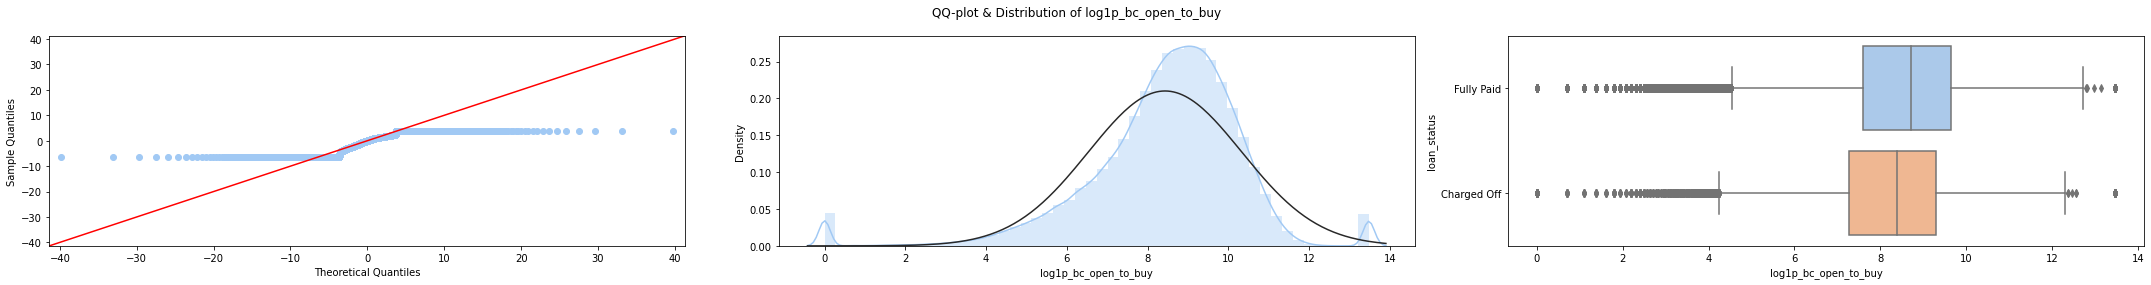

In [122]:
df["log1p_bc_open_to_buy"] = np.log1p(df["bc_open_to_buy"])
plot_feat("log1p_bc_open_to_buy", cont=True)

In [123]:
df.drop(["bc_open_to_buy"], axis=1, inplace=True)

### 6.6) `installment`

Data Dictionary: "The monthly payment owed by the borrower if the loan originates"

In [124]:
df["installment"].dtype

dtype('float64')

In [125]:
df["installment"].sample(n=5)

253537    148.38
315790    867.25
156566    478.42
418528    519.15
96708     163.11
Name: installment, dtype: float64

In [126]:
df["installment"].describe()

count    438991.000000
mean        443.451421
std         277.262393
min           6.680000
25%         241.130000
50%         370.910000
75%         593.490000
max        1719.830000
Name: installment, dtype: float64

In [127]:
df.groupby("loan_status")["installment"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,438.093038,275.296843,6.68,237.85,365.31,584.96,1719.83
1,51368.0,483.885792,288.478790,30.12,271.45,409.72,645.61,1717.63


In [128]:
df_class_0 = df.loc[df["loan_status"] == 0]["installment"]
df_class_1 = df.loc[df["loan_status"] == 1]["installment"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8966520329.5000
U-test p-value: 0.0000


The means of the two groups are very close here, but the quartiles indicate that the Fully Paid group generally pays lower installment amounts. This is also an indication that this feature is not normally distributed.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: installment
Skewness: 1.0459
Kurtosis: 0.7359
Shapiro stat, p: 0.9215, 0.0000
Pearson corr w/target: 0.0531



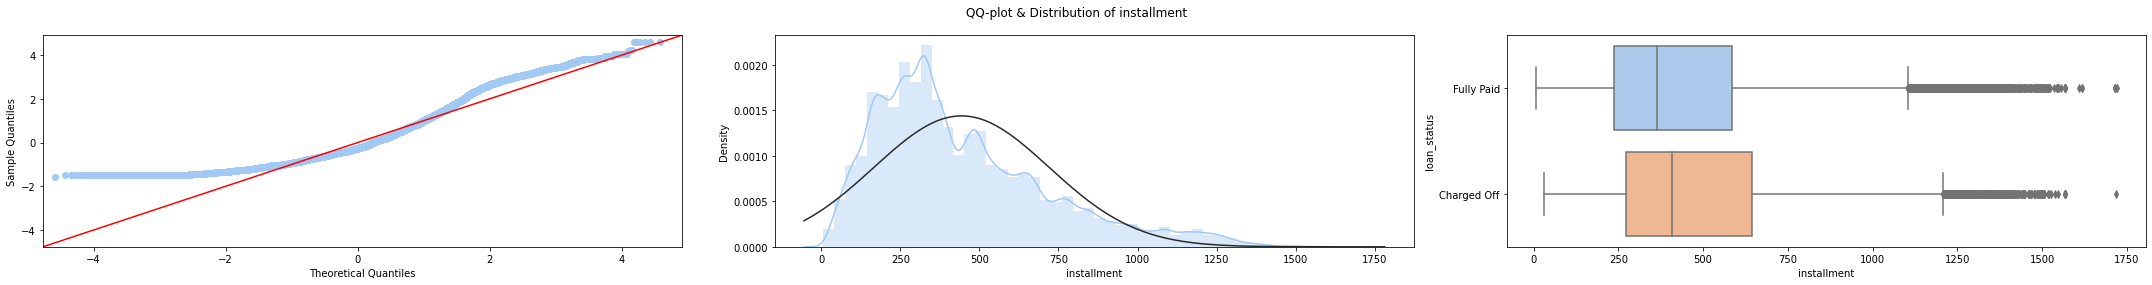

In [129]:
plot_feat("installment", cont=True)

Sure enough, there's some skew in the data, but not enough to warrant transforming it.

### 6.7) `annual_inc`

Data Dictionary: "The self-reported annual income provided by the borrower during registration"

In [130]:
df["annual_inc"].dtype

dtype('float64')

It would make more sense for this to be an int.

In [131]:
df["annual_inc"] = df["annual_inc"].astype("int")

In [132]:
df["annual_inc"].sample(n=5)

63870     63804
128913    74000
338933    53000
419194    51600
53236     84000
Name: annual_inc, dtype: int32

In [133]:
df["annual_inc"].describe()

count    4.389910e+05
mean     7.978605e+04
std      8.194272e+04
min      0.000000e+00
25%      4.759450e+04
50%      6.626400e+04
75%      9.500000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

In [134]:
df.groupby("loan_status")["annual_inc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,80615.841802,83657.007357,0.0,48000.0,67500.0,96000.0,10999200.0
1,51368.0,73524.422637,67291.191157,0.0,45000.0,62400.0,88000.0,5604824.0


In [135]:
df_class_0 = df.loc[df["loan_status"] == 0]["annual_inc"]
df_class_1 = df.loc[df["loan_status"] == 1]["annual_inc"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10755057533.0000
U-test p-value: 0.0000


The Fully Paid group tends to make quite a bit more money annually (~$6500 more per year). There's an intuitive relationship between this feature & one's ability to pay off their debts.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: annual_inc
Skewness: 47.4477
Kurtosis: 4382.9963
Shapiro stat, p: 0.3565, 0.0000
Pearson corr w/target: -0.0278



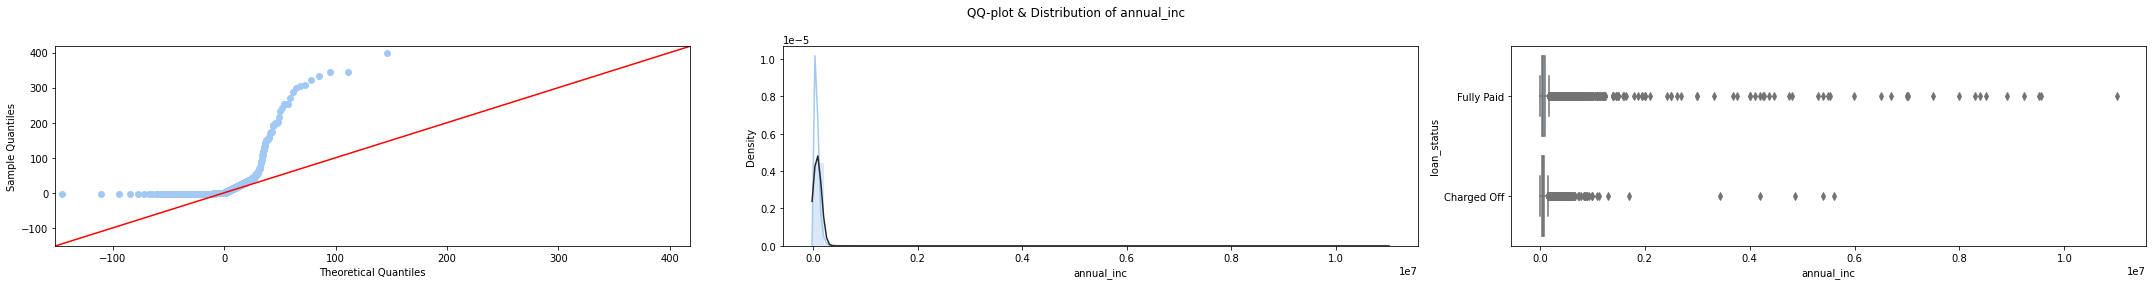

In [136]:
plot_feat("annual_inc", cont=True)

The distribution is very skewed & the range of the scales is quite large. Therefore, we'll log transform the data.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: log1p_annual_inc
Skewness: -3.4573
Kurtosis: 62.5433
Shapiro stat, p: 0.8543, 0.0000
Pearson corr w/target: -0.0386



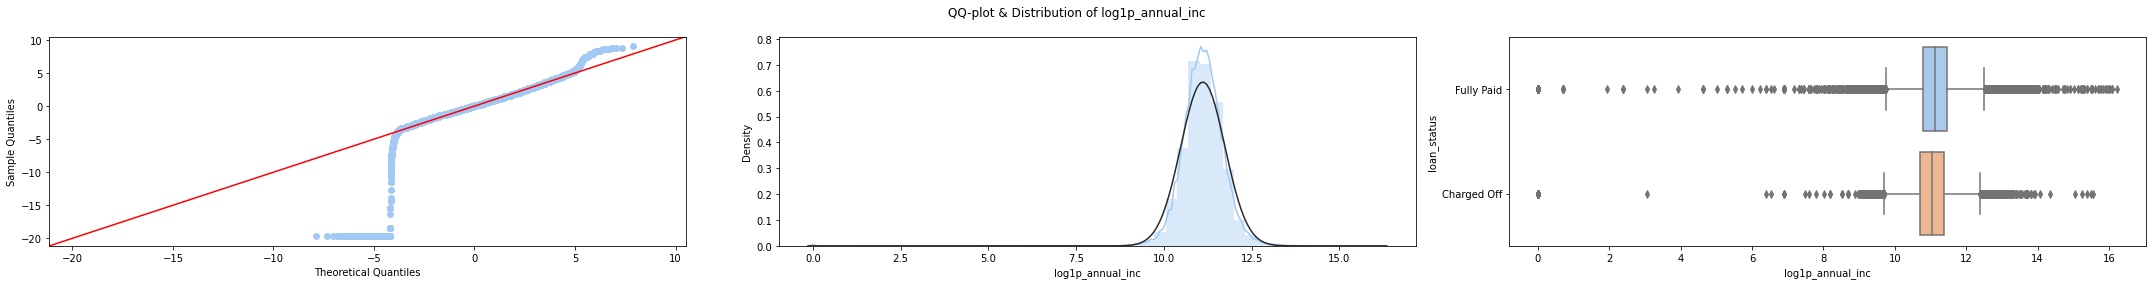

In [137]:
df["log1p_annual_inc"] = np.log1p(df["annual_inc"])
plot_feat("log1p_annual_inc", cont=True)

In [138]:
df.drop(["annual_inc"], axis=1, inplace=True)

### 6.8) `total_rev_hi_lim`

Data Dictionary: "Total revolving high credit/credit limit"

In [139]:
df["total_rev_hi_lim"].dtype

dtype('int64')

In [140]:
df["total_rev_hi_lim"].sample(n=5)

169878    13300
29438     16900
145608    34100
187279    60600
106401    30400
Name: total_rev_hi_lim, dtype: int64

In [141]:
df["total_rev_hi_lim"].describe()

count    4.389910e+05
mean     3.479833e+04
std      3.550777e+04
min      0.000000e+00
25%      1.460000e+04
50%      2.550000e+04
75%      4.330000e+04
max      2.175000e+06
Name: total_rev_hi_lim, dtype: float64

In [142]:
df.groupby("loan_status")["total_rev_hi_lim"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,35434.137334,36216.529737,0.0,14800.0,25900.0,44200.0,2175000.0
1,51368.0,30000.566909,29174.424114,0.0,13300.0,22600.0,37400.0,944500.0


In [143]:
df_class_0 = df.loc[df["loan_status"] == 0]["total_rev_hi_lim"]
df_class_1 = df.loc[df["loan_status"] == 1]["total_rev_hi_lim"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10926713537.5000
U-test p-value: 0.0000


The Fully Paid group tends to have higher credit limits.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: total_rev_hi_lim
Skewness: 5.9401
Kurtosis: 112.7162
Shapiro stat, p: 0.6514, 0.0000
Pearson corr w/target: -0.0492



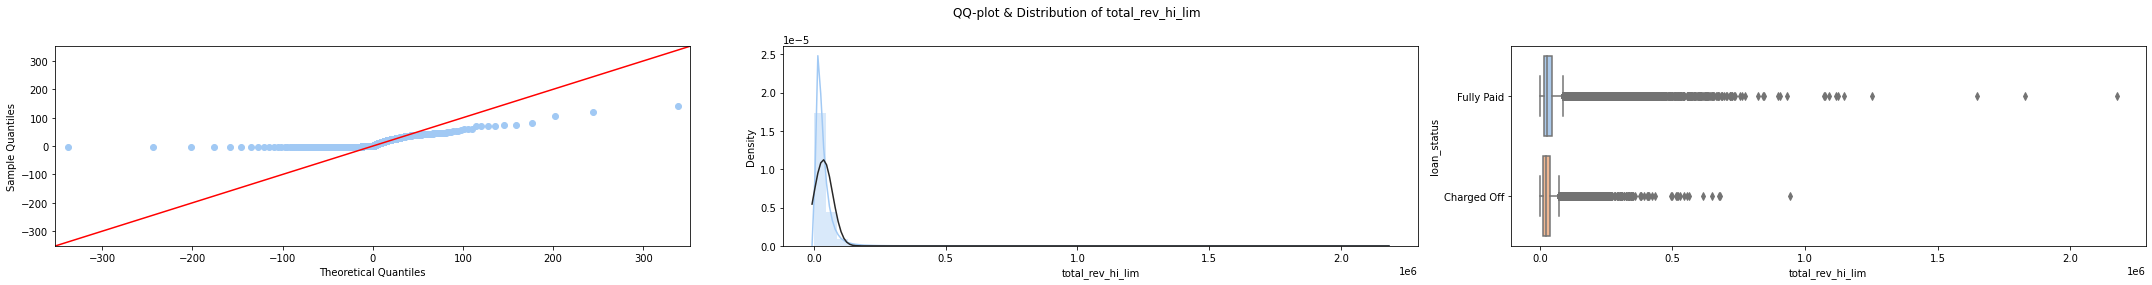

In [144]:
plot_feat("total_rev_hi_lim", cont=True)

The distribution is very skewed & the range of the scales is quite large. Therefore, we'll log transform the data.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: log1p_total_rev_hi_lim
Skewness: -1.2192
Kurtosis: 11.3227
Shapiro stat, p: 0.9494, 0.0000
Pearson corr w/target: -0.0497



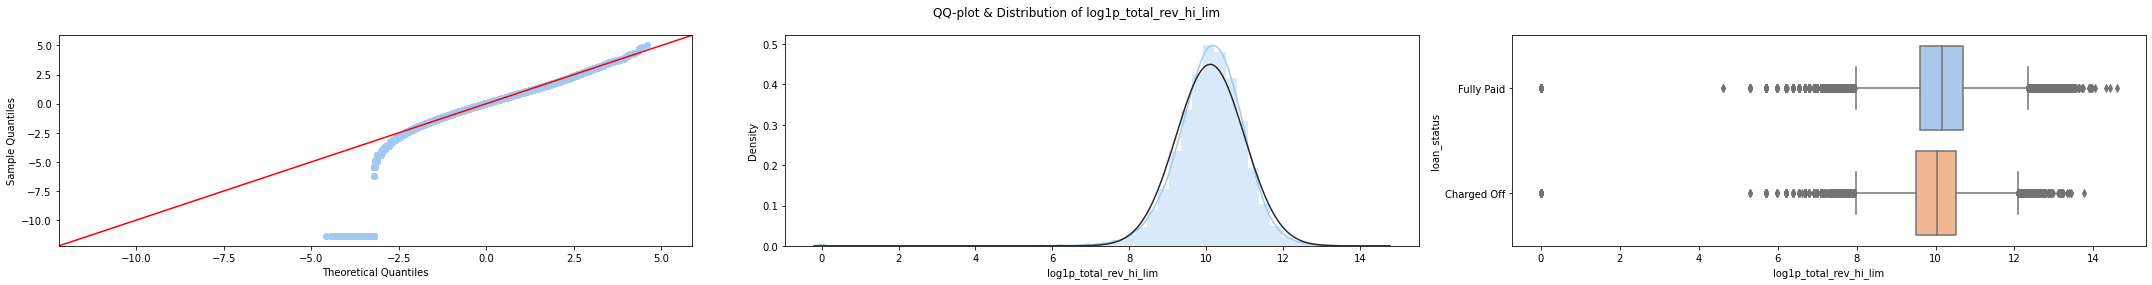

In [145]:
df["log1p_total_rev_hi_lim"] = np.log1p(df["total_rev_hi_lim"])
plot_feat("log1p_total_rev_hi_lim", cont=True)

In [146]:
df.drop(["total_rev_hi_lim"], axis=1, inplace=True)

### 6.9) `dti`

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income"

In [147]:
df["dti"].dtype

dtype('float64')

In [148]:
df["dti"].sample(n=5)

3515      21.75
2190      26.10
211320    31.30
285277    23.37
21607     23.43
Name: dti, dtype: float64

In [149]:
df["dti"].describe()

count    438706.000000
mean         19.053124
std          14.427149
min          -1.000000
25%          12.130000
50%          18.100000
75%          24.800000
max         999.000000
Name: dti, dtype: float64

It looks like this was encoded as a percentage instead of the ratio. We could divide all values by 100, but it shouldn't matter.

In [150]:
df.groupby("loan_status")["dti"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387361.0,18.842525,14.451149,-1.0,11.96,17.84,24.50,999.0
1,51345.0,20.641941,14.144216,0.0,13.68,20.09,26.86,999.0


In [151]:
df_class_0 = df.loc[df["loan_status"] == 0]["dti"]
df_class_1 = df.loc[df["loan_status"] == 1]["dti"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8730591928.0000
U-test p-value: 0.0000


There are some weird values in this feature (e.g., -1 & 999). With these being percentages, the bounds should be 0 - Inf, with values > 100 indicating that someone has more debt than they do income. Maybe someone before us mangled the data. It could be that this feature orginally had some percentages in it & later mixed it with ratio data (or vice versa). Then they might've tried to transform all of it while not realizing that part of the data was already transformed. A possible solution then would be to grab all values above 100, divide by 100, and then reinsert those rows. This method would help get everything onto the same scale (except the -1 value(s)), but I think we'd still have some pretty extreme looking values (e.g., 999 would become 99).

Disregarding the weird values, individuals in the Fully Paid group tend to have lower debt-to-income ratios, which makes sense.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: dti
Skewness: 30.8761
Kurtosis: 1875.6559
Shapiro stat, p: nan, 1.0000
Pearson corr w/target: 0.0401



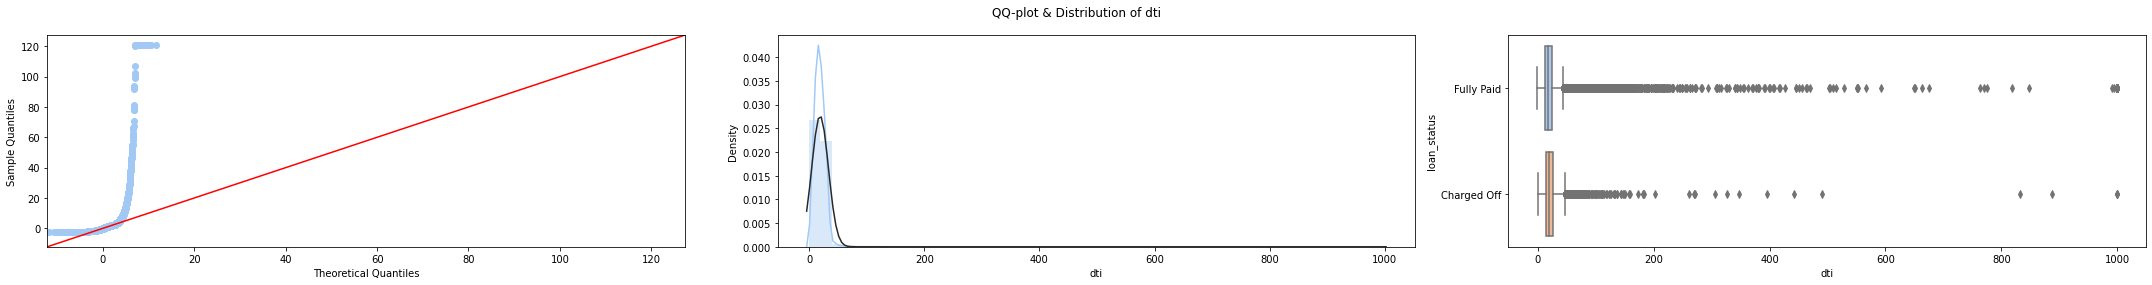

In [152]:
plot_feat("dti", cont=True)

### 6.10) `total_bc_limit`

Data Dictionary: "Total bankcard high credit/credit limit"

In [153]:
df["total_bc_limit"].dtype

dtype('int64')

It would make more sense for this to be an int.

In [154]:
df["total_bc_limit"] = df["total_bc_limit"].astype("int")

In [155]:
df["total_bc_limit"].sample(n=5)

70154      4000
384867     7700
31731     45300
395639    13000
97522     21300
Name: total_bc_limit, dtype: int32

In [156]:
df["total_bc_limit"].describe()

count    438991.000000
mean      23299.998446
std       23030.807798
min           0.000000
25%        8400.000000
50%       16400.000000
75%       30400.000000
max      719500.000000
Name: total_bc_limit, dtype: float64

In [157]:
df.groupby("loan_status")["total_bc_limit"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,23822.800775,23431.044489,0.0,8500.0,16800.0,31100.0,719500.0
1,51368.0,19354.931339,19299.642770,0.0,7100.0,13800.0,25000.0,363800.0


In [158]:
df_class_0 = df.loc[df["loan_status"] == 0]["total_bc_limit"]
df_class_1 = df.loc[df["loan_status"] == 1]["total_bc_limit"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 11136771195.0000
U-test p-value: 0.0000


The Fully Paid group tends to have higher credit limits.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: total_bc_limit
Skewness: 2.7684
Kurtosis: 16.2263
Shapiro stat, p: 0.7686, 0.0000
Pearson corr w/target: -0.0624



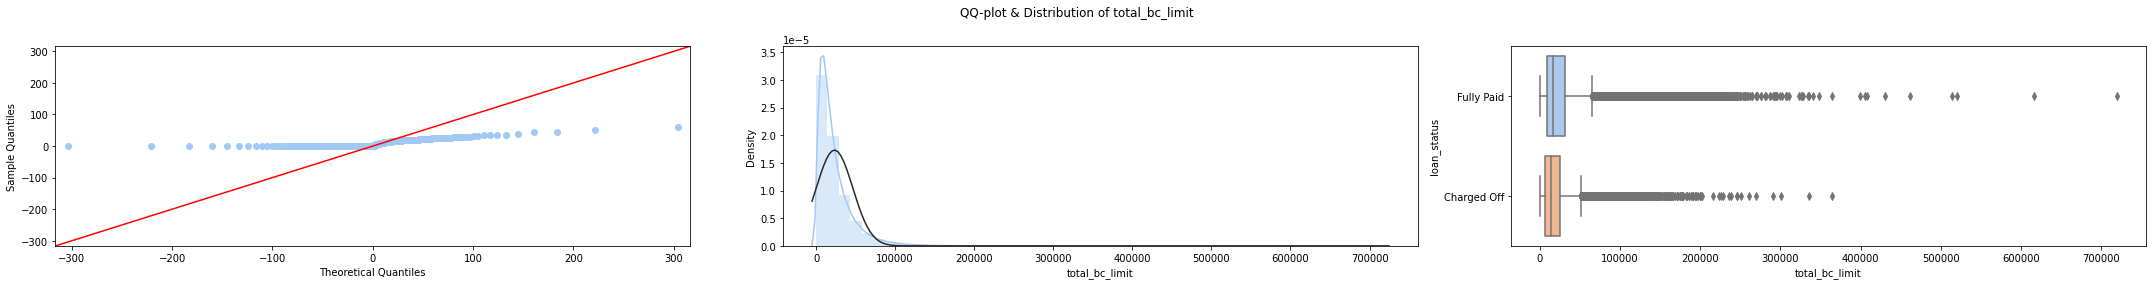

In [159]:
plot_feat("total_bc_limit", cont=True)

The distribution is very skewed & the range of the scales is quite large. Therefore, we'll log transform the data.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: log1p_total_bc_limit
Skewness: -3.5788
Kurtosis: 21.2522
Shapiro stat, p: 0.7280, 0.0000
Pearson corr w/target: -0.0451



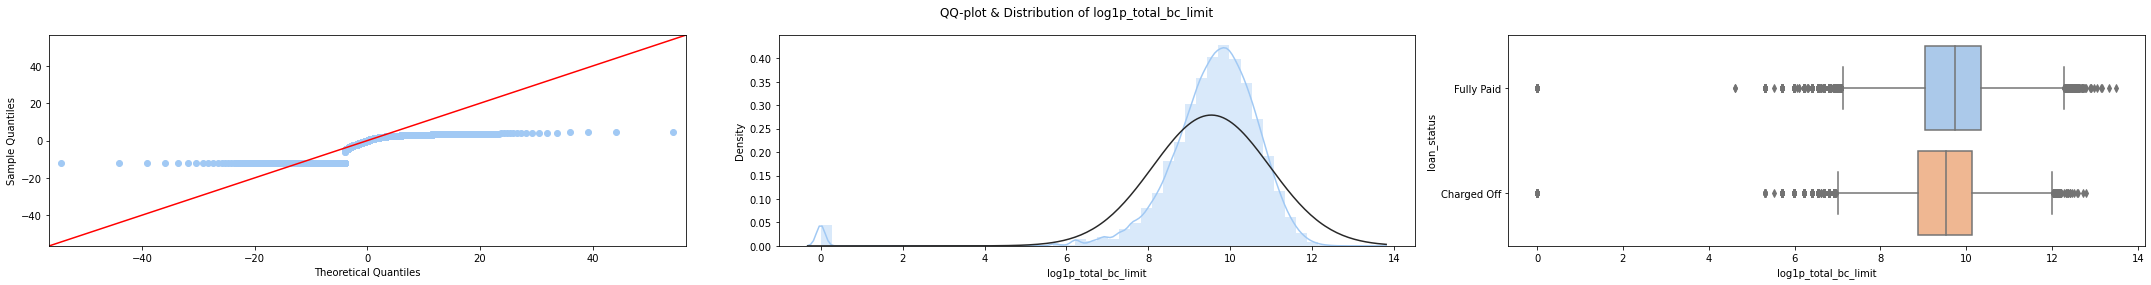

In [160]:
df["log1p_total_bc_limit"] = np.log1p(df["total_bc_limit"])
plot_feat("log1p_total_bc_limit", cont=True)

In [161]:
df.drop(["total_bc_limit"], axis=1, inplace=True)

### 6.11) `bc_util`

Data Dictionary: "Ratio of total current balance to high credit/credit limit for all bankcard accounts"

In [162]:
df["bc_util"].dtype

dtype('float64')

In [163]:
df["bc_util"].sample(n=5)

228792    85.4
143078    37.6
421939    43.0
407442    84.2
18189      NaN
Name: bc_util, dtype: float64

In [164]:
df["bc_util"].describe()

count    433602.000000
mean         56.734858
std          28.526861
min           0.000000
25%          34.100000
50%          58.300000
75%          81.900000
max         252.300000
Name: bc_util, dtype: float64

In [165]:
df.groupby("loan_status")["bc_util"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,382888.0,56.235611,28.545184,0.0,33.5,57.6,81.3,252.3
1,50714.0,60.504145,28.103604,0.0,39.2,63.4,85.3,189.8


In [166]:
df_class_0 = df.loc[df["loan_status"] == 0]["bc_util"]
df_class_1 = df.loc[df["loan_status"] == 1]["bc_util"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8860229696.0000
U-test p-value: 0.0000


The Charged Off group has higher credit utilization relative to their limits.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: bc_util
Skewness: -0.2103
Kurtosis: -1.0343
Shapiro stat, p: nan, 1.0000
Pearson corr w/target: 0.0481



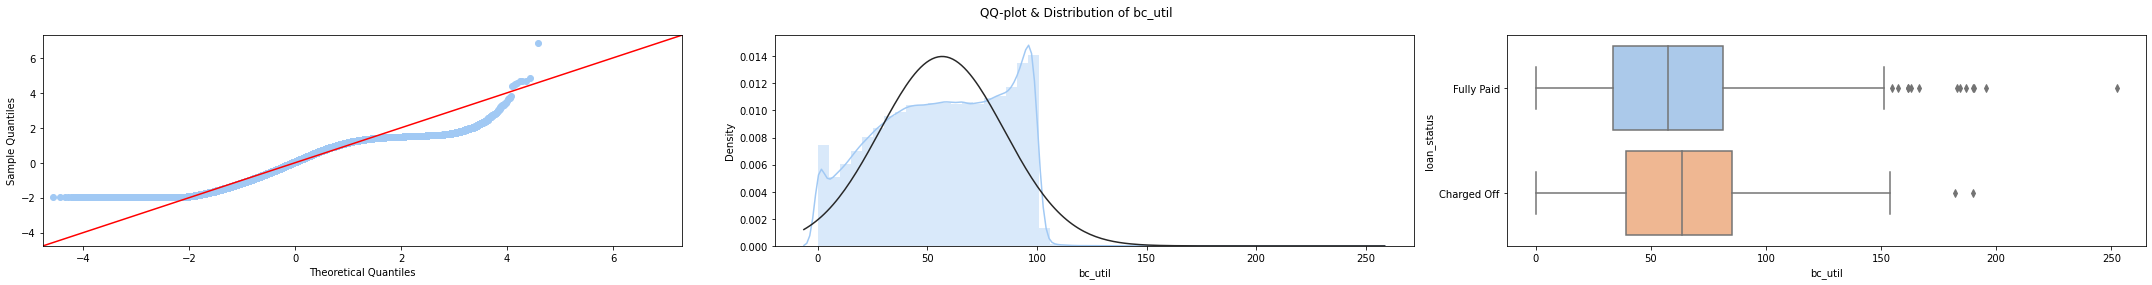

In [167]:
plot_feat("bc_util", cont=True)

### 6.12) `revol_util`

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit"

In [168]:
df["revol_util"].dtype

dtype('float64')

In [169]:
df["revol_util"].sample(n=5)

198172    0.873
270212    0.880
408898    0.841
71626     0.529
285722    0.361
Name: revol_util, dtype: float64

In [170]:
df["revol_util"].describe()

count    438632.000000
mean          0.492409
std           0.245152
min           0.000000
25%           0.305000
50%           0.488000
75%           0.678000
max           1.720000
Name: revol_util, dtype: float64

In [171]:
df.groupby("loan_status")["revol_util"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387297.0,0.488701,0.245627,0.0,0.300,0.483,0.675,1.720
1,51335.0,0.520383,0.239695,0.0,0.345,0.521,0.700,1.526


In [172]:
df_class_0 = df.loc[df["loan_status"] == 0]["revol_util"]
df_class_1 = df.loc[df["loan_status"] == 1]["revol_util"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9189894427.5000
U-test p-value: 0.0000


The Fully Paid group carries a slightly lower revolving credit utilization rate.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: revol_util
Skewness: 0.0565
Kurtosis: -0.8069
Shapiro stat, p: nan, 1.0000
Pearson corr w/target: 0.0415



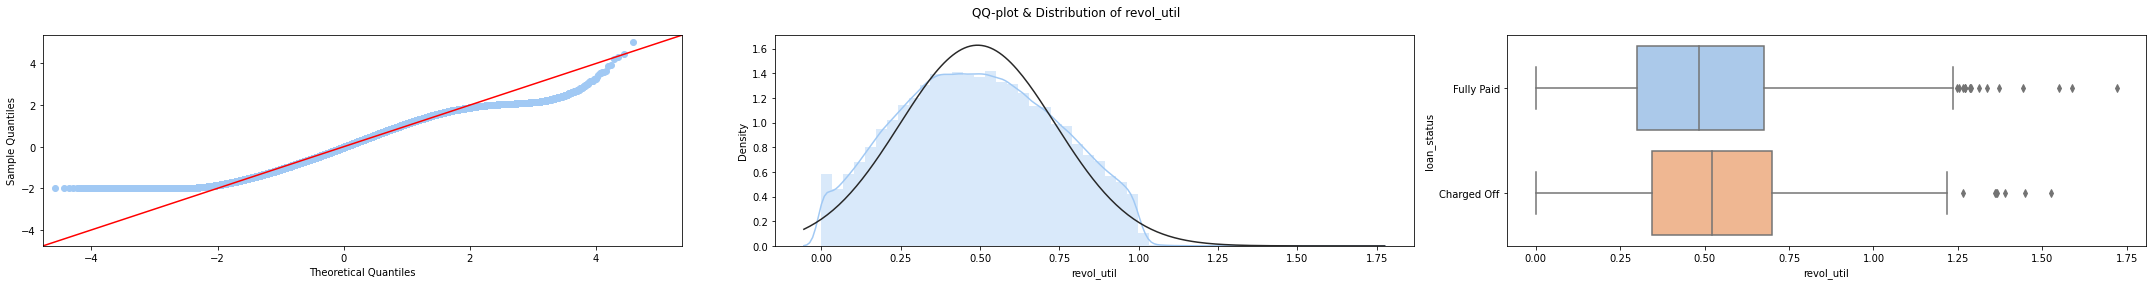

In [173]:
plot_feat("revol_util", cont=True)

### 6.13) `pct_tl_nvr_dlq`

Data Dictionary: "Percent of trades never delinquent"

In [174]:
df["pct_tl_nvr_dlq"].dtype

dtype('float64')

In [175]:
df["pct_tl_nvr_dlq"].sample(n=5)

164286    100.0
242711    100.0
293427    100.0
177861    100.0
362393     77.8
Name: pct_tl_nvr_dlq, dtype: float64

In [176]:
df["pct_tl_nvr_dlq"].describe()

count    438991.000000
mean         93.669153
std           9.456735
min           0.000000
25%          90.600000
50%          97.600000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64

In [177]:
df.groupby("loan_status")["pct_tl_nvr_dlq"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,93.691537,9.469473,0.0,90.9,97.6,100.0,100.0
1,51368.0,93.500245,9.358424,10.5,90.0,97.0,100.0,100.0


In [178]:
df_class_0 = df.loc[df["loan_status"] == 0]["pct_tl_nvr_dlq"]
df_class_1 = df.loc[df["loan_status"] == 1]["pct_tl_nvr_dlq"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10184552600.5000
U-test p-value: 0.0000


Most people, regardless of group, have never had a deliquent trade. The Charged Off group is, however, more likely to have had one.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: pct_tl_nvr_dlq
Skewness: -2.2344
Kurtosis: 6.6337
Shapiro stat, p: 0.7090, 0.0000
Pearson corr w/target: -0.0065



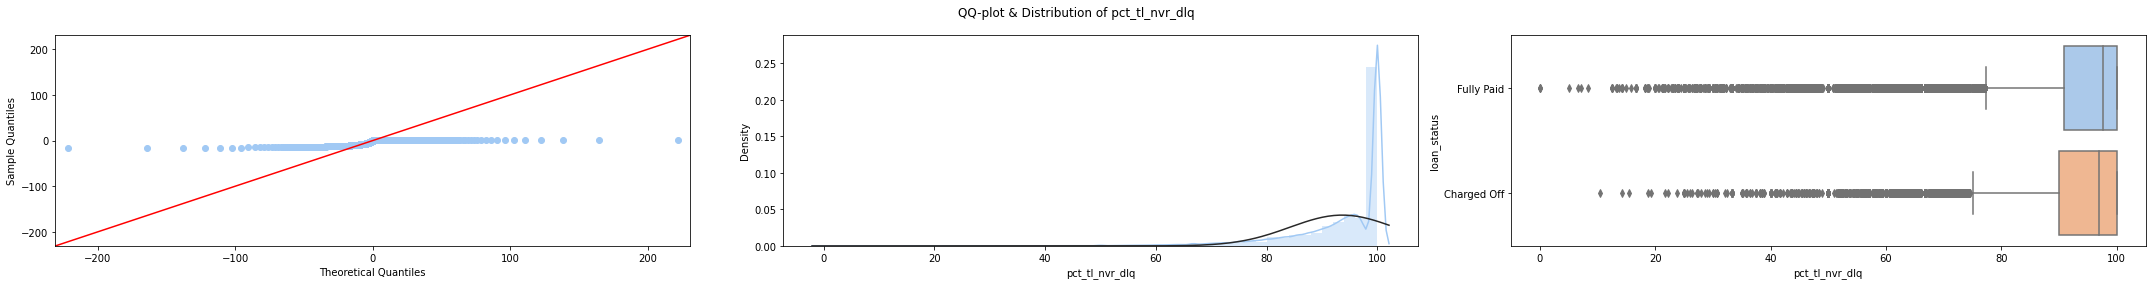

In [179]:
plot_feat("pct_tl_nvr_dlq", cont=True)

### 6.14) `mths_since_recent_bc`

Data Dictionary: "Months since most recent bankcard account opened"

In [180]:
df["mths_since_recent_bc"].dtype

dtype('float64')

It would make more sense for this to be an int.

In [181]:
df["mths_since_recent_bc"] = df["mths_since_recent_bc"].astype("int")

In [182]:
df["mths_since_recent_bc"].sample(n=5)

324612      1
135305    128
326092    656
73968      20
379148      7
Name: mths_since_recent_bc, dtype: int32

In [183]:
df["mths_since_recent_bc"].describe()

count    438991.000000
mean         31.457483
std          73.860424
min           0.000000
25%           6.000000
50%          14.000000
75%          30.000000
max         656.000000
Name: mths_since_recent_bc, dtype: float64

In [184]:
df.groupby("loan_status")["mths_since_recent_bc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,32.005652,73.953652,0.0,6.0,14.0,30.0,656.0
1,51368.0,27.320998,73.021244,0.0,5.0,11.0,24.0,656.0


In [185]:
df_class_0 = df.loc[df["loan_status"] == 0]["mths_since_recent_bc"]
df_class_1 = df.loc[df["loan_status"] == 1]["mths_since_recent_bc"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10989570682.0000
U-test p-value: 0.0000


Those in the Charged Off group tend to have younger accounts.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: mths_since_recent_bc
Skewness: 6.9989
Kurtosis: 54.8691
Shapiro stat, p: 0.3316, 0.0000
Pearson corr w/target: -0.0204



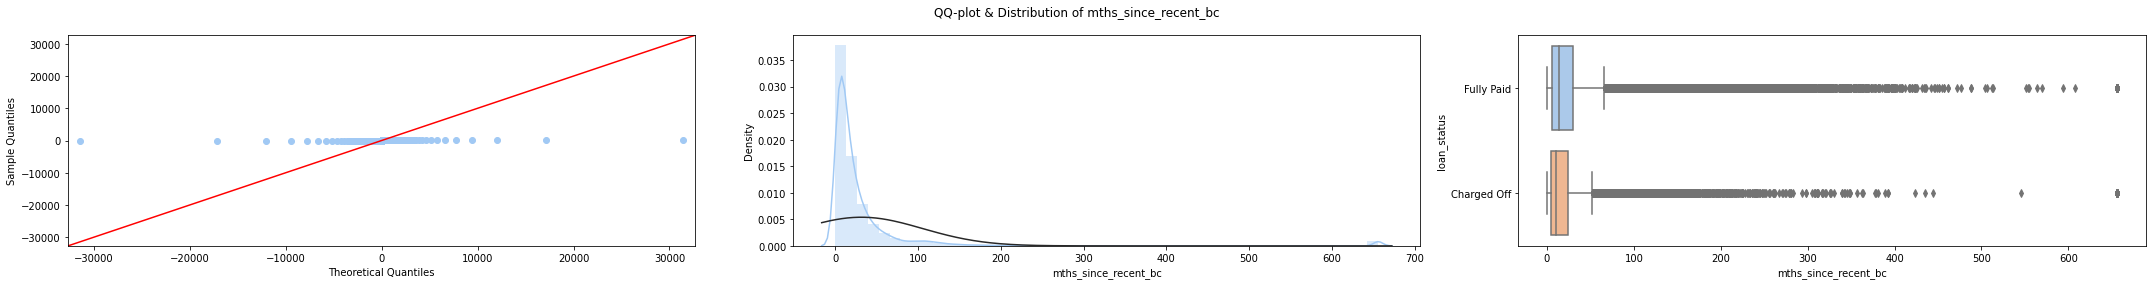

In [186]:
plot_feat("mths_since_recent_bc", cont=True)

The distribution is very skewed & the range of the scales is quite large. Therefore, we'll log transform the data.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: log1p_mths_since_recent_bc
Skewness: 0.4277
Kurtosis: 0.5031
Shapiro stat, p: 0.9844, 0.0000
Pearson corr w/target: -0.0553



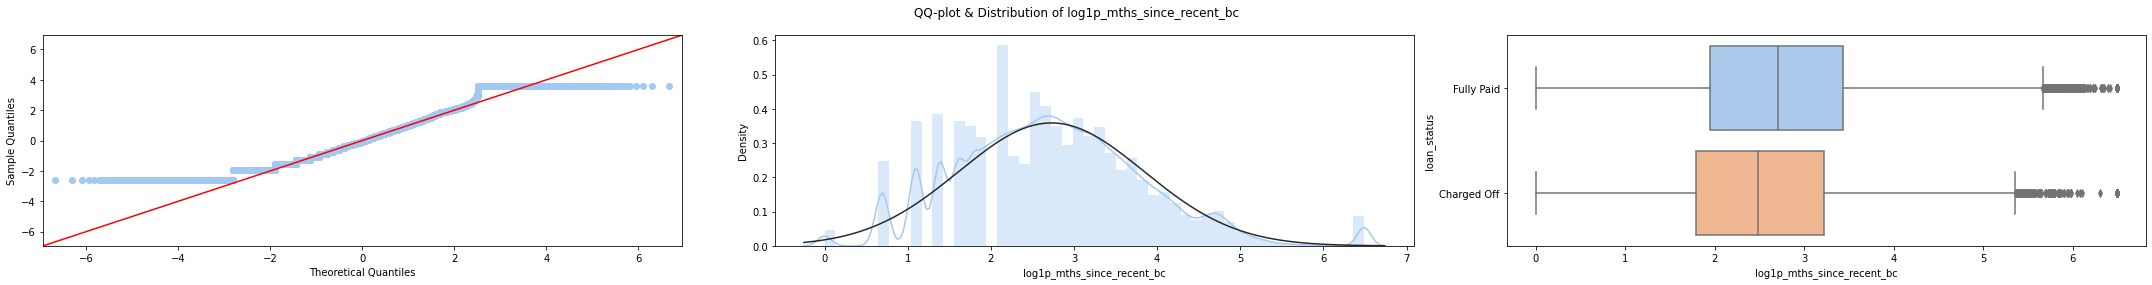

In [187]:
df["log1p_mths_since_recent_bc"] = np.log1p(df["mths_since_recent_bc"])
plot_feat("log1p_mths_since_recent_bc", cont=True)

In [188]:
df.drop(["mths_since_recent_bc"], axis=1, inplace=True)

### 6.15) `il_util`

Data Dictionary: "Ratio of total current balance to high credit/credit limit on all install acct"

In [189]:
df["il_util"].dtype

dtype('float64')

In [190]:
df["il_util"].sample(n=5)

31942     81.0
146790    33.0
411244     NaN
339365    23.0
72162     87.0
Name: il_util, dtype: float64

In [191]:
df["il_util"].describe()

count    379426.000000
mean         69.752653
std          23.727198
min           0.000000
25%          56.000000
50%          73.000000
75%          86.000000
max        1000.000000
Name: il_util, dtype: float64

In [192]:
df.groupby("loan_status")["il_util"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,334169.0,69.249859,23.817567,0.0,55.0,72.0,86.0,1000.0
1,45257.0,73.465188,22.707196,0.0,61.0,77.0,89.0,558.0


In [193]:
df_class_0 = df.loc[df["loan_status"] == 0]["il_util"]
df_class_1 = df.loc[df["loan_status"] == 1]["il_util"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 6697978071.5000
U-test p-value: 0.0000


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: il_util
Skewness: -0.1702
Kurtosis: 7.8502
Shapiro stat, p: nan, 1.0000
Pearson corr w/target: 0.0576



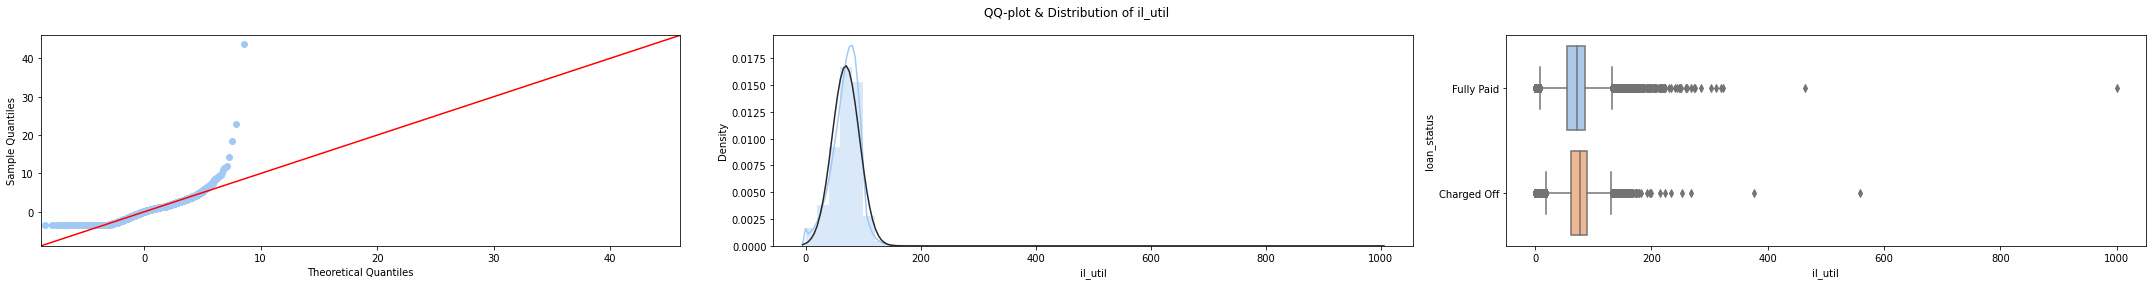

In [194]:
plot_feat("il_util", cont=True)

### 6.16) `percent_bc_gt_75`

Data Dictionary: "Percentage of all bankcard accounts > 75% of limit"

In [195]:
df["percent_bc_gt_75"].dtype

dtype('float64')

In [196]:
df["percent_bc_gt_75"].sample(n=5)

166475      0.0
266112     25.0
75764     100.0
119449      0.0
182103     50.0
Name: percent_bc_gt_75, dtype: float64

In [197]:
df["percent_bc_gt_75"].describe()

count    433774.000000
mean         40.881013
std          36.189174
min           0.000000
25%           0.000000
50%          33.300000
75%          66.700000
max         100.000000
Name: percent_bc_gt_75, dtype: float64

In [198]:
df.groupby("loan_status")["percent_bc_gt_75"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,383036.0,40.222481,36.134069,0.0,0.0,33.3,66.7,100.0
1,50738.0,45.852462,36.218496,0.0,12.5,45.5,75.0,100.0


In [199]:
df_class_0 = df.loc[df["loan_status"] == 0]["percent_bc_gt_75"]
df_class_1 = df.loc[df["loan_status"] == 1]["percent_bc_gt_75"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8834118713.0000
U-test p-value: 0.0000


Those in the Charged Off group have more accounts with high utilization rates.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: percent_bc_gt_75
Skewness: 0.3816
Kurtosis: -1.2067
Shapiro stat, p: nan, 1.0000
Pearson corr w/target: 0.0500



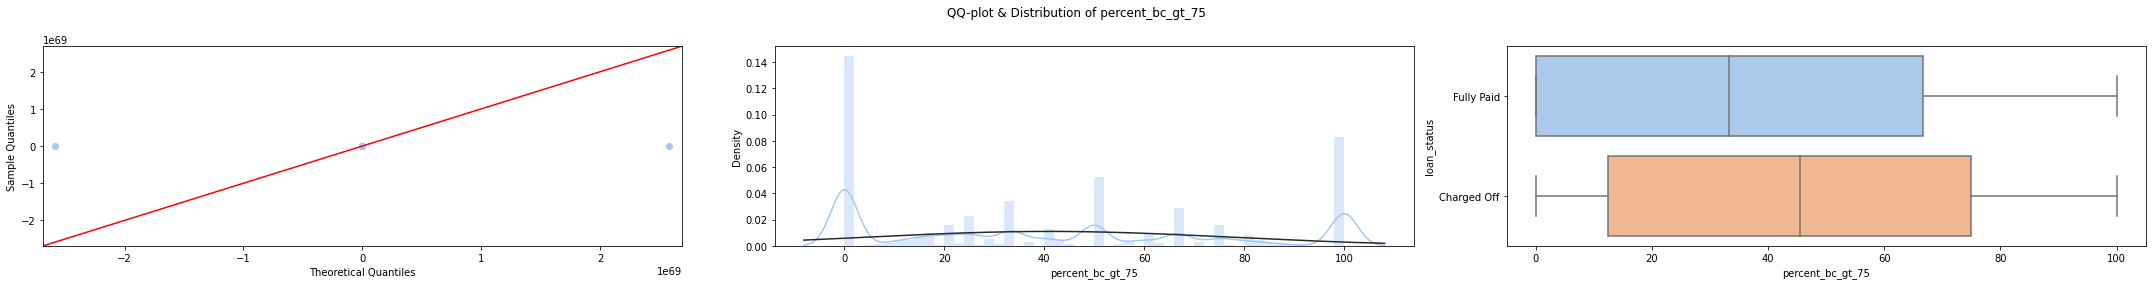

In [200]:
plot_feat("percent_bc_gt_75", cont=True)

### 6.17) `all_util`

Data Dictionary: "Balance to credit limit on all trades"

In [201]:
df["all_util"].dtype

dtype('float64')

In [202]:
df["all_util"].sample(n=5)

68971     50.0
268553    50.0
205793    56.0
209144    66.0
241504    48.0
Name: all_util, dtype: float64

In [203]:
df["all_util"].describe()

count    438917.000000
mean         58.632459
std          20.661954
min           0.000000
25%          45.000000
50%          60.000000
75%          73.000000
max         210.000000
Name: all_util, dtype: float64

In [204]:
df.groupby("loan_status")["all_util"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387556.0,58.142552,20.727958,0.0,44.0,59.0,73.0,210.0
1,51361.0,62.329160,19.769501,0.0,50.0,64.0,76.0,168.0


In [205]:
df_class_0 = df.loc[df["loan_status"] == 0]["all_util"]
df_class_1 = df.loc[df["loan_status"] == 1]["all_util"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8733845540.5000
U-test p-value: 0.0000


Those in the Charged Off group have more credit debt.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: all_util
Skewness: -0.1417
Kurtosis: -0.0327
Shapiro stat, p: nan, 1.0000
Pearson corr w/target: 0.0651



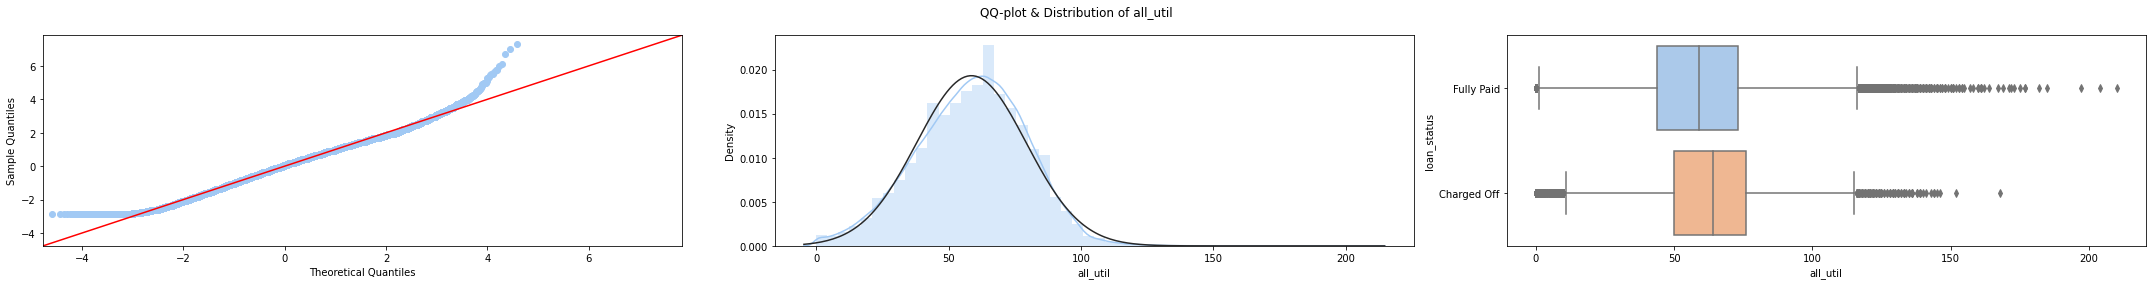

In [206]:
plot_feat("all_util", cont=True)

### 6.18) `int_rate`

Data Dictionary: "Interest Rate on the loan"

In [207]:
df["int_rate"].dtype

dtype('float64')

In [208]:
df["int_rate"].sample(n=5)

427453    0.1408
280771    0.1806
144913    0.1699
162682    0.1099
59898     0.0975
Name: int_rate, dtype: float64

In [209]:
df["int_rate"].describe()

count    438991.000000
mean          0.131441
std           0.050626
min           0.053200
25%           0.094900
50%           0.126200
75%           0.155900
max           0.309900
Name: int_rate, dtype: float64

In [210]:
df.groupby("loan_status")["int_rate"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,0.127587,0.048635,0.0532,0.0944,0.1199,0.1505,0.3099
1,51368.0,0.160518,0.055651,0.0532,0.1199,0.1499,0.1903,0.3099


In [211]:
df_class_0 = df.loc[df["loan_status"] == 0]["int_rate"]
df_class_1 = df.loc[df["loan_status"] == 1]["int_rate"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 6385718891.0000
U-test p-value: 0.0000


Fully Paid loans typically have substantially lower interest rates.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: int_rate
Skewness: 0.9746
Kurtosis: 1.0642
Shapiro stat, p: 0.9409, 0.0000
Pearson corr w/target: 0.2091



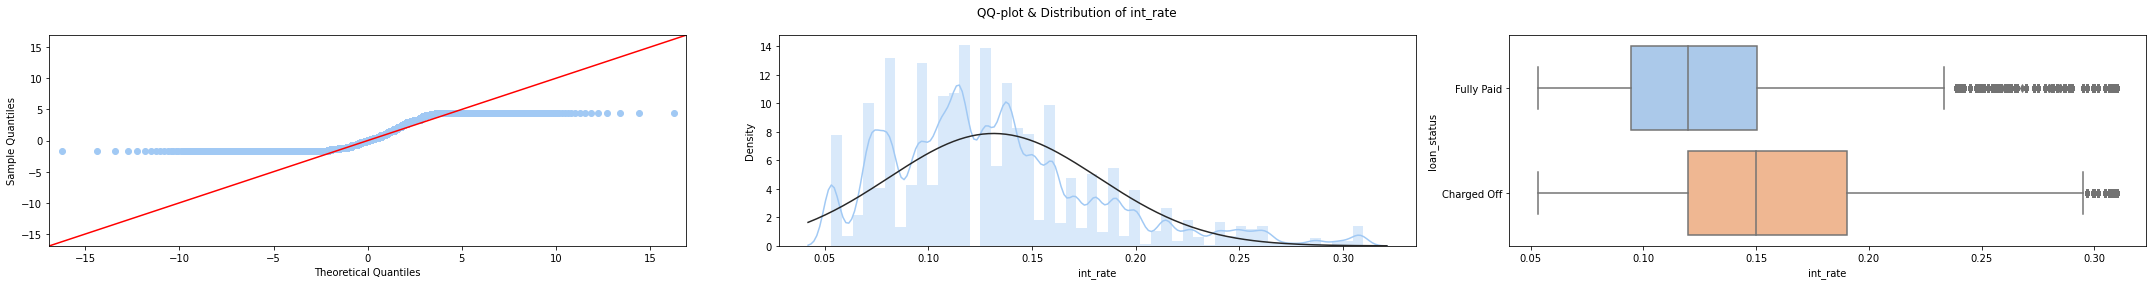

In [212]:
plot_feat("int_rate", cont=True)

### 6.19) `mths_since_recent_revol_delinq`

Data Dictionary: "Months since most recent revolving delinquency"

In [213]:
df["mths_since_recent_revol_delinq"].dtype

dtype('float64')

It would make more sense for this to be an int.

In [214]:
df["mths_since_recent_revol_delinq"] = df["mths_since_recent_revol_delinq"].astype("int")

In [215]:
df["mths_since_recent_revol_delinq"].sample(n=5)

292098     39
225323    188
242408     33
235464    188
194516    188
Name: mths_since_recent_revol_delinq, dtype: int32

In [216]:
df["mths_since_recent_revol_delinq"].describe()

count    438991.000000
mean        134.454747
std          74.239386
min           0.000000
25%          46.000000
50%         188.000000
75%         188.000000
max         188.000000
Name: mths_since_recent_revol_delinq, dtype: float64

In [217]:
df.groupby("loan_status")["mths_since_recent_revol_delinq"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,134.819232,74.086788,0.0,47.0,188.0,188.0,188.0
1,51368.0,131.704349,75.324815,0.0,43.0,188.0,188.0,188.0


In [218]:
df_class_0 = df.loc[df["loan_status"] == 0]["mths_since_recent_revol_delinq"]
df_class_1 = df.loc[df["loan_status"] == 1]["mths_since_recent_revol_delinq"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10166865537.0000
U-test p-value: 0.0000


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: mths_since_recent_revol_delinq
Skewness: -0.7237
Kurtosis: -1.3680
Shapiro stat, p: 0.6617, 0.0000
Pearson corr w/target: -0.0135



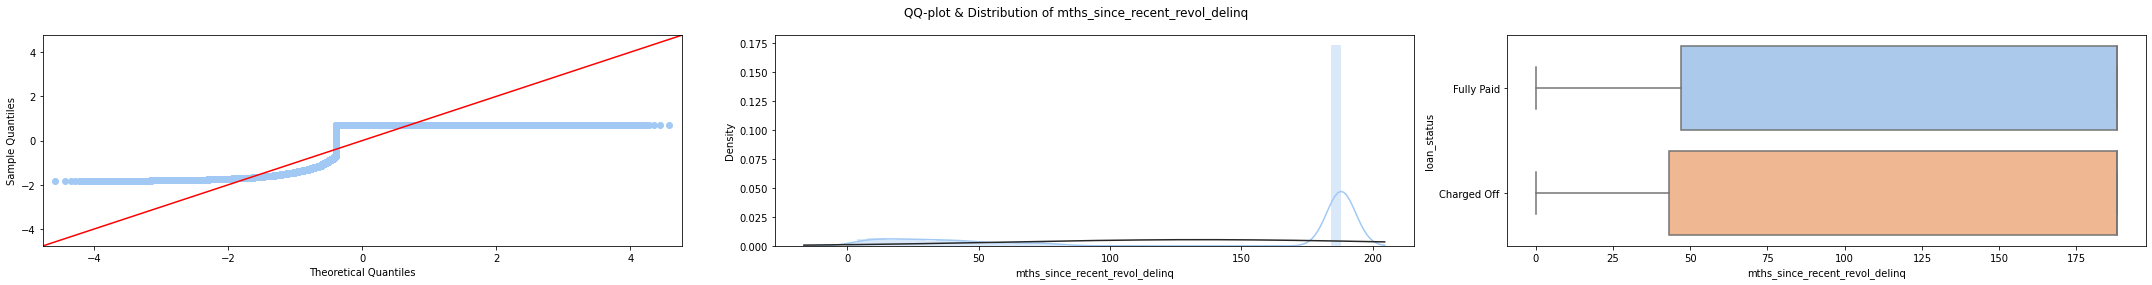

In [219]:
plot_feat("mths_since_recent_revol_delinq", cont=True)

### 6.20) `mths_since_recent_bc_dlq`

Data Dictionary: "Months since most recent bankcard delinquency"

In [220]:
df["mths_since_recent_bc_dlq"].dtype

dtype('float64')

It would make more sense for this to be an int.

In [221]:
df["mths_since_recent_bc_dlq"] = df["mths_since_recent_bc_dlq"].astype("int")

In [222]:
df["mths_since_recent_bc_dlq"].sample(n=5)

220351    188
301097    188
185231     54
106970    188
324611    188
Name: mths_since_recent_bc_dlq, dtype: int32

In [223]:
df["mths_since_recent_bc_dlq"].describe()

count    438991.000000
mean        151.446820
std          65.345021
min           0.000000
25%         188.000000
50%         188.000000
75%         188.000000
max         188.000000
Name: mths_since_recent_bc_dlq, dtype: float64

In [224]:
df.groupby("loan_status")["mths_since_recent_bc_dlq"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,151.779492,65.117386,0.0,188.0,188.0,188.0,188.0
1,51368.0,148.936478,66.985229,0.0,79.0,188.0,188.0,188.0


In [225]:
df_class_0 = df.loc[df["loan_status"] == 0]["mths_since_recent_bc_dlq"]
df_class_1 = df.loc[df["loan_status"] == 1]["mths_since_recent_bc_dlq"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10144081525.5000
U-test p-value: 0.0000


Those in the Charged Off group have more recent bank card delinquencies.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: mths_since_recent_bc_dlq
Skewness: -1.2899
Kurtosis: -0.2062
Shapiro stat, p: 0.5678, 0.0000
Pearson corr w/target: -0.0140



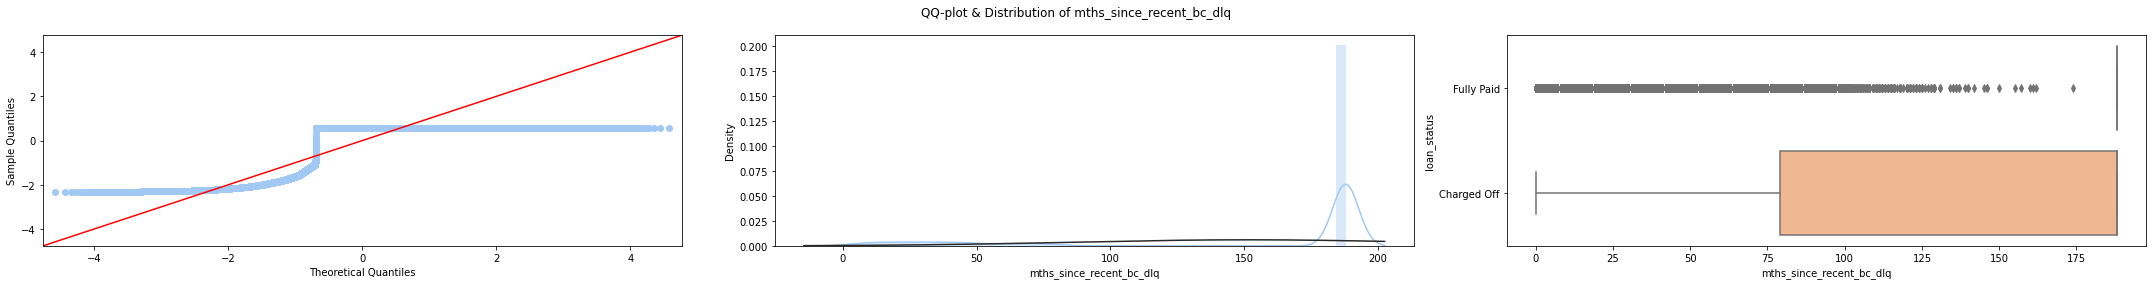

In [226]:
plot_feat("mths_since_recent_bc_dlq", cont=True)

### 6.21) `mths_since_last_delinq`

Data Dictionary: "The number of months since the borrower's last delinquency"

In [227]:
df["mths_since_last_delinq"].dtype

dtype('float64')

It would make more sense for this to be an int.

In [228]:
df["mths_since_last_delinq"] = df["mths_since_last_delinq"].astype("int")

In [229]:
df["mths_since_last_delinq"].sample(n=5)

120642     48
386617    195
26843     195
320769     12
402048     47
Name: mths_since_last_delinq, dtype: int32

In [230]:
df["mths_since_last_delinq"].describe()

count    438991.000000
mean        112.288218
std          82.059350
min           0.000000
25%          30.000000
50%          78.000000
75%         195.000000
max         195.000000
Name: mths_since_last_delinq, dtype: float64

In [231]:
df.groupby("loan_status")["mths_since_last_delinq"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,112.832533,82.011101,0.0,30.0,79.0,195.0,195.0
1,51368.0,108.180813,82.307344,0.0,27.0,71.0,195.0,195.0


In [232]:
df_class_0 = df.loc[df["loan_status"] == 0]["mths_since_last_delinq"]
df_class_1 = df.loc[df["loan_status"] == 1]["mths_since_last_delinq"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10277662515.0000
U-test p-value: 0.0000


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: mths_since_last_delinq
Skewness: -0.0497
Kurtosis: -1.8812
Shapiro stat, p: 0.7374, 0.0000
Pearson corr w/target: -0.0182



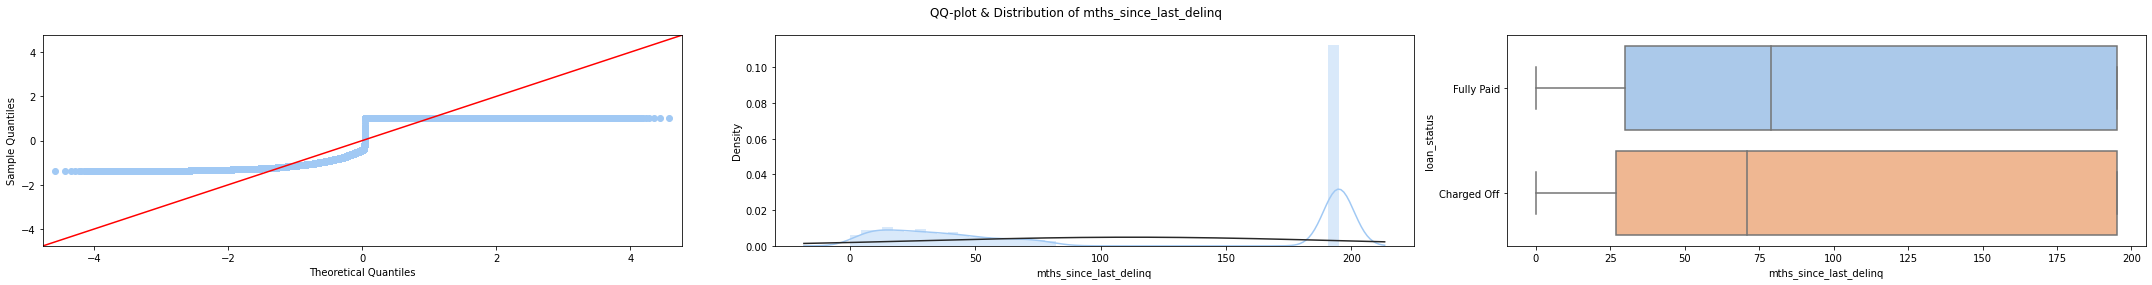

In [233]:
plot_feat("mths_since_last_delinq", cont=True)

### 6.22) `total_acc`

Data Dictionary: "The total number of credit lines currently in the borrower's credit file"

In [234]:
df["total_acc"].dtype

dtype('int64')

In [235]:
df["total_acc"].sample(n=5)

245683    26
307834    15
85729     37
316233     8
398250    21
Name: total_acc, dtype: int64

In [236]:
df["total_acc"].describe()

count    438991.000000
mean         23.908381
std          11.938711
min           2.000000
25%          15.000000
50%          22.000000
75%          30.000000
max         173.000000
Name: total_acc, dtype: float64

In [237]:
df.groupby("loan_status")["total_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,23.86563,11.907683,2.0,15.0,22.0,30.0,173.0
1,51368.0,24.23098,12.165569,2.0,15.0,22.0,31.0,144.0


In [238]:
df_class_0 = df.loc[df["loan_status"] == 0]["total_acc"]
df_class_1 = df.loc[df["loan_status"] == 1]["total_acc"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9810736237.5000
U-test p-value: 0.0000


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: total_acc
Skewness: 1.0668
Kurtosis: 2.1538
Shapiro stat, p: 0.9427, 0.0000
Pearson corr w/target: 0.0098



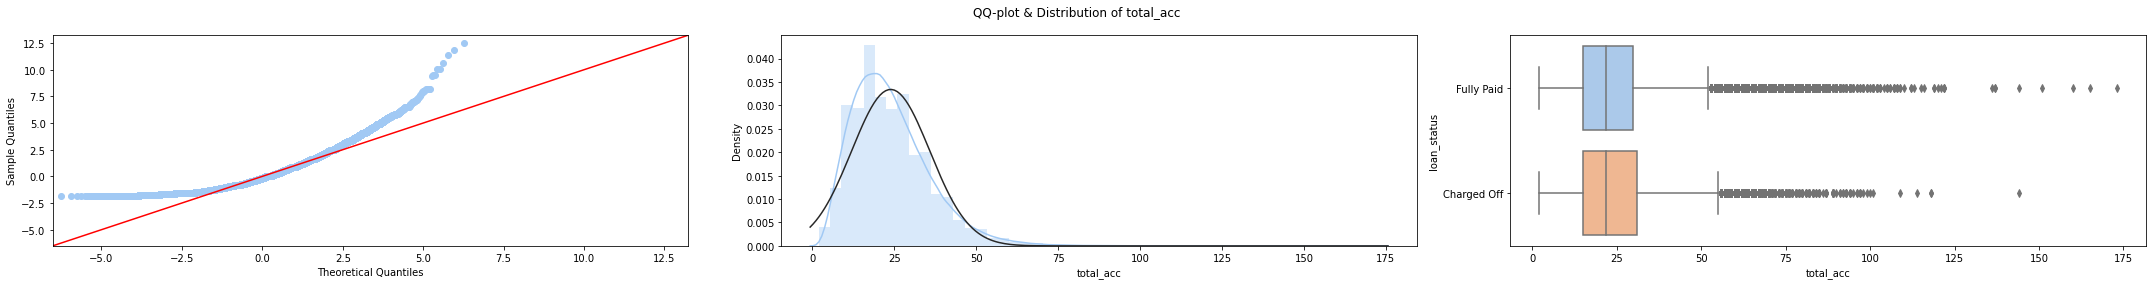

In [239]:
plot_feat("total_acc", cont=True)

### 6.23) `num_rev_accts`

Data Dictionary: "Number of revolving accounts"

In [240]:
df["num_rev_accts"].dtype

dtype('int64')

In [241]:
df["num_rev_accts"].sample(n=5)

61334     12
230581    10
358243    17
203549    19
437797    15
Name: num_rev_accts, dtype: int64

In [242]:
df["num_rev_accts"].describe()

count    438991.000000
mean         13.677654
std           7.987081
min           2.000000
25%           8.000000
50%          12.000000
75%          18.000000
max         143.000000
Name: num_rev_accts, dtype: float64

In [243]:
df.groupby("loan_status")["num_rev_accts"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,13.639616,7.966454,2.0,8.0,12.0,18.0,143.0
1,51368.0,13.964686,8.135396,2.0,8.0,12.0,18.0,83.0


In [244]:
df_class_0 = df.loc[df["loan_status"] == 0]["num_rev_accts"]
df_class_1 = df.loc[df["loan_status"] == 1]["num_rev_accts"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9725324436.0000
U-test p-value: 0.0000


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: num_rev_accts
Skewness: 1.4270
Kurtosis: 3.8240
Shapiro stat, p: 0.9065, 0.0000
Pearson corr w/target: 0.0131



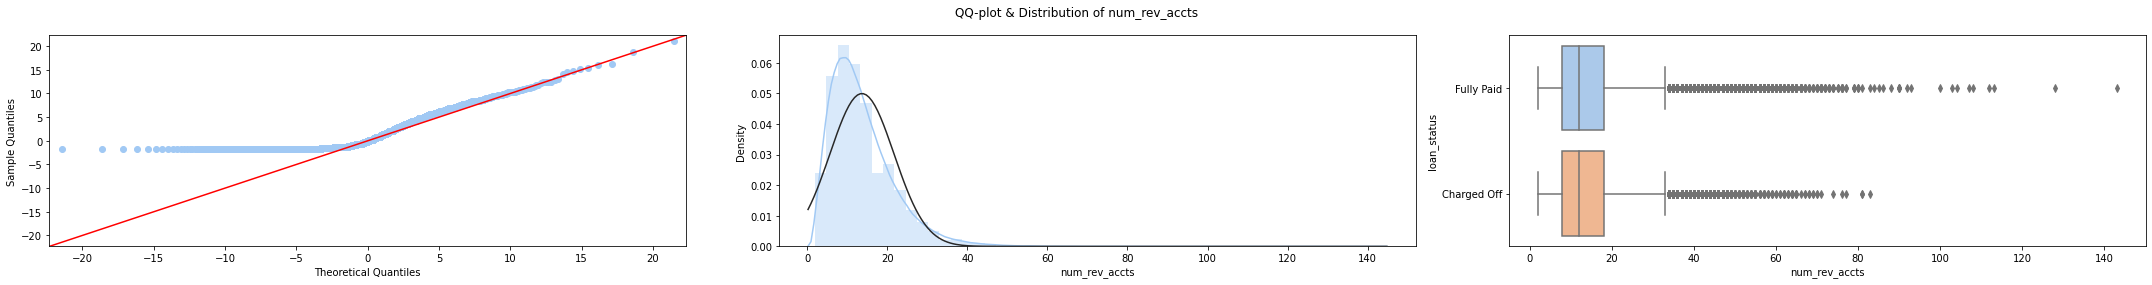

In [245]:
plot_feat("num_rev_accts", cont=True)

### 6.24) `num_sats`

Data Dictionary: "Number of satisfactory accounts"

In [246]:
df["num_sats"].dtype

dtype('int64')

In [247]:
df["num_sats"].sample(n=5)

411159     4
386337    19
219905    18
362374     3
335639    12
Name: num_sats, dtype: int64

In [248]:
df["num_sats"].describe()

count    438991.000000
mean         11.698960
std           5.745511
min           0.000000
25%           8.000000
50%          11.000000
75%          15.000000
max          97.000000
Name: num_sats, dtype: float64

In [249]:
df.groupby("loan_status")["num_sats"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,11.662755,5.735987,0.0,8.0,11.0,15.0,97.0
1,51368.0,11.972162,5.809666,0.0,8.0,11.0,15.0,68.0


In [250]:
df_class_0 = df.loc[df["loan_status"] == 0]["num_sats"]
df_class_1 = df.loc[df["loan_status"] == 1]["num_sats"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9625804603.5000
U-test p-value: 0.0000


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: num_sats
Skewness: 1.3373
Kurtosis: 3.5570
Shapiro stat, p: 0.9188, 0.0000
Pearson corr w/target: 0.0173



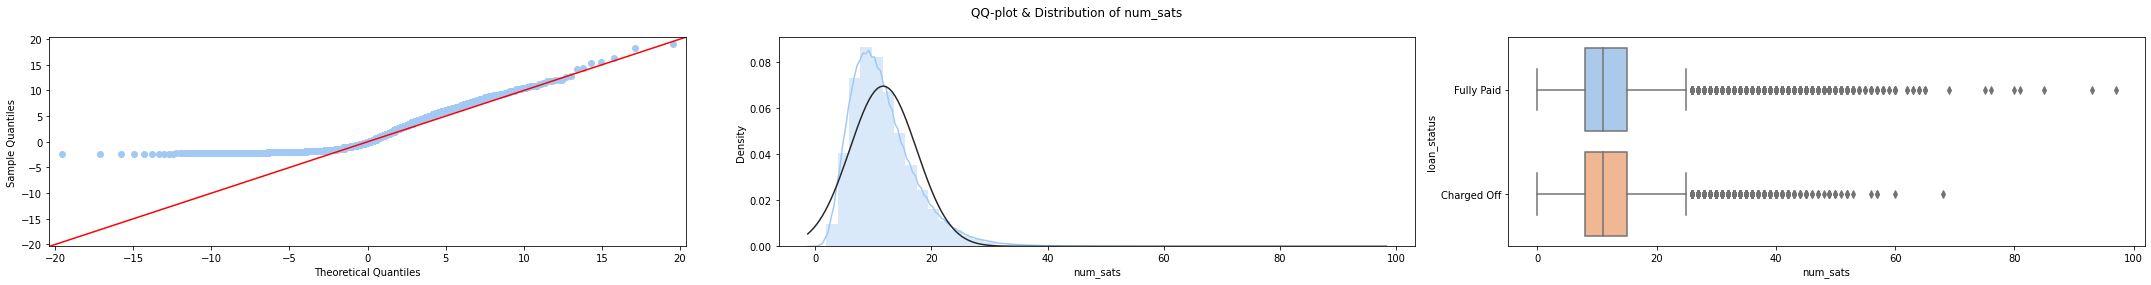

In [251]:
plot_feat("num_sats", cont=True)

### 6.25) `open_acc`

Data Dictionary: "The number of open credit lines in the borrower's credit file"

In [252]:
df["open_acc"].dtype

dtype('int64')

In [253]:
df["open_acc"].sample(n=5)

277510     8
163574    13
110451     5
400423     9
366839    17
Name: open_acc, dtype: int64

In [254]:
df["open_acc"].describe()

count    438991.000000
mean         11.746391
std           5.767707
min           0.000000
25%           8.000000
50%          11.000000
75%          15.000000
max          97.000000
Name: open_acc, dtype: float64

In [255]:
df.groupby("loan_status")["open_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,11.708722,5.757695,0.0,8.0,11.0,15.0,97.0
1,51368.0,12.030642,5.834927,1.0,8.0,11.0,15.0,68.0


In [256]:
df_class_0 = df.loc[df["loan_status"] == 0]["open_acc"]
df_class_1 = df.loc[df["loan_status"] == 1]["open_acc"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9614582654.5000
U-test p-value: 0.0000


c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: open_acc
Skewness: 1.3414
Kurtosis: 3.6229
Shapiro stat, p: 0.9194, 0.0000
Pearson corr w/target: 0.0179



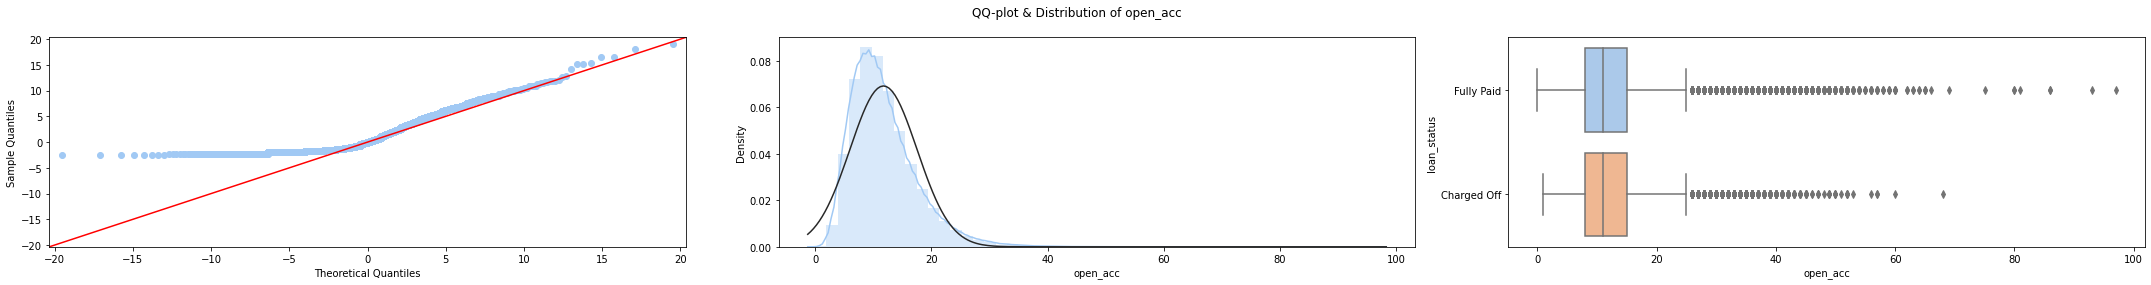

In [257]:
plot_feat("open_acc", cont=True)

### 6.26) `earliest_cr_line_yr`

Derived Feature: "The year the borrower's earliest reported credit line was opened"

In [258]:
df["earliest_cr_line_yr"].dtype

dtype('int64')

In [259]:
df["earliest_cr_line_yr"].sample(n=5)

103978    2005
11276     1987
79720     1987
389686    2006
241024    2003
Name: earliest_cr_line_yr, dtype: int64

In [260]:
df["earliest_cr_line_yr"].describe()

count    438991.000000
mean       1999.874241
std           7.793951
min        1933.000000
25%        1996.000000
50%        2001.000000
75%        2005.000000
max        2014.000000
Name: earliest_cr_line_yr, dtype: float64

In [261]:
df.groupby("loan_status")["earliest_cr_line_yr"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,1999.804901,7.809517,1933.0,1996.0,2001.0,2005.0,2014.0
1,51368.0,2000.397485,7.655320,1951.0,1997.0,2002.0,2005.0,2014.0


In [262]:
df_class_0 = df.loc[df["loan_status"] == 0]["earliest_cr_line_yr"]
df_class_1 = df.loc[df["loan_status"] == 1]["earliest_cr_line_yr"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9472910933.5000
U-test p-value: 0.0000


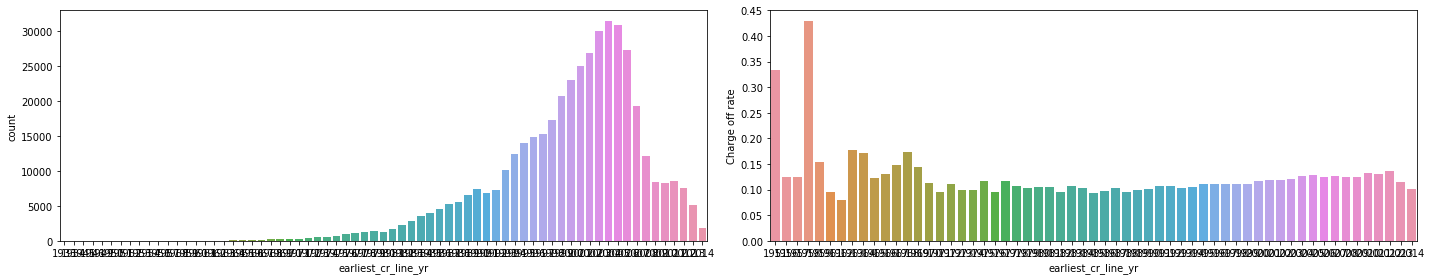

In [263]:
plot_feat("earliest_cr_line_yr", cont=False)

### 6.27) `sec_app_earliest_cr_line_yr`

Derived Feature: "Earliest credit line at time of application for the secondary applicant"

In [264]:
df["sec_app_earliest_cr_line_yr"].dtype

dtype('int64')

In [265]:
df["sec_app_earliest_cr_line_yr"].sample(n=5)

222169    0
345101    0
4550      0
196571    0
318036    0
Name: sec_app_earliest_cr_line_yr, dtype: int64

In [266]:
df["sec_app_earliest_cr_line_yr"].describe()

count    438991.000000
mean         85.580073
std         404.782649
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2014.000000
Name: sec_app_earliest_cr_line_yr, dtype: float64

In [267]:
df.groupby("loan_status")["sec_app_earliest_cr_line_yr"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,89.285912,413.043792,0.0,0.0,0.0,0.0,2014.0
1,51368.0,57.615811,334.639392,0.0,0.0,0.0,0.0,2014.0


In [268]:
df_class_0 = df.loc[df["loan_status"] == 0]["sec_app_earliest_cr_line_yr"]
df_class_1 = df.loc[df["loan_status"] == 1]["sec_app_earliest_cr_line_yr"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10111917713.5000
U-test p-value: 0.0000


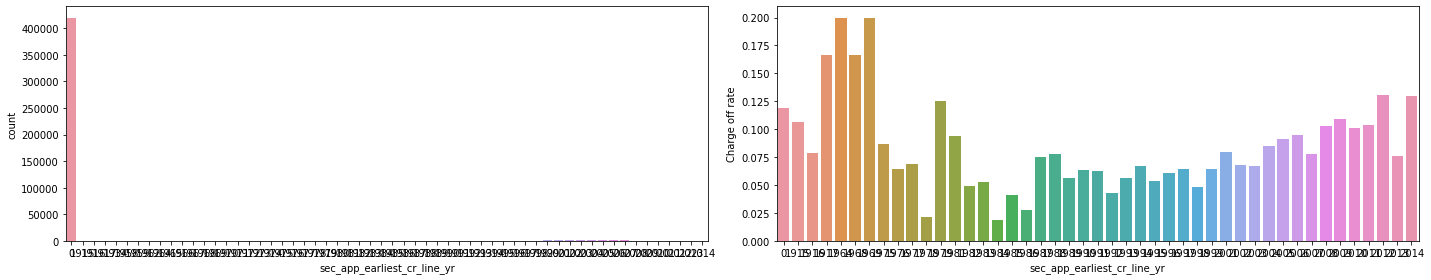

In [269]:
plot_feat("sec_app_earliest_cr_line_yr", cont=False)

### 6.28) `addr_state`

Data Dictionary: "The state provided by the borrower in the loan application"

In [270]:
df["addr_state"].dtype

dtype('O')

In [271]:
df["addr_state"].sample(n=5)

276754    OK
98048     TN
158322    IN
133885    FL
366803    NE
Name: addr_state, dtype: object

In [272]:
df["addr_state"].describe()

count     438991
unique        50
top           CA
freq       58548
Name: addr_state, dtype: object

In [273]:
df.groupby("loan_status")["addr_state"].describe()

,count,unique,top,freq
loan_status,,,,
0,387623,50,CA,51277
1,51368,50,CA,7271


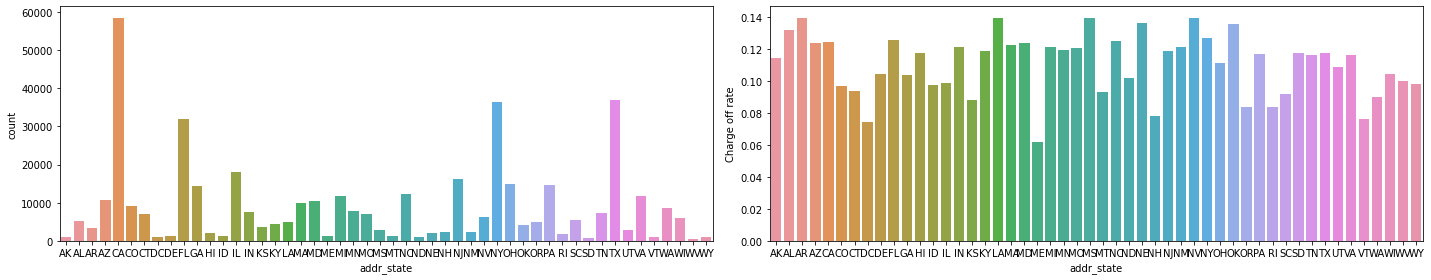

In [274]:
plot_feat("addr_state", cont=False)

### 6.29) `acc_open_past_24mths`

Data Dictionary: "Number of trades opened in past 24 months"

In [275]:
df["acc_open_past_24mths"].dtype

dtype('int64')

In [276]:
df["acc_open_past_24mths"].sample(n=5)

25379     4
410733    3
360624    4
391825    9
5580      2
Name: acc_open_past_24mths, dtype: int64

In [277]:
df["acc_open_past_24mths"].describe()

count    438991.000000
mean          4.661007
std           3.261466
min           0.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          61.000000
Name: acc_open_past_24mths, dtype: float64

In [278]:
df.groupby("loan_status")["acc_open_past_24mths"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,4.542107,3.194922,0.0,2.0,4.0,6.0,61.0
1,51368.0,5.558227,3.601075,0.0,3.0,5.0,7.0,56.0


In [279]:
df_class_0 = df.loc[df["loan_status"] == 0]["acc_open_past_24mths"]
df_class_1 = df.loc[df["loan_status"] == 1]["acc_open_past_24mths"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8195905887.0000
U-test p-value: 0.0000


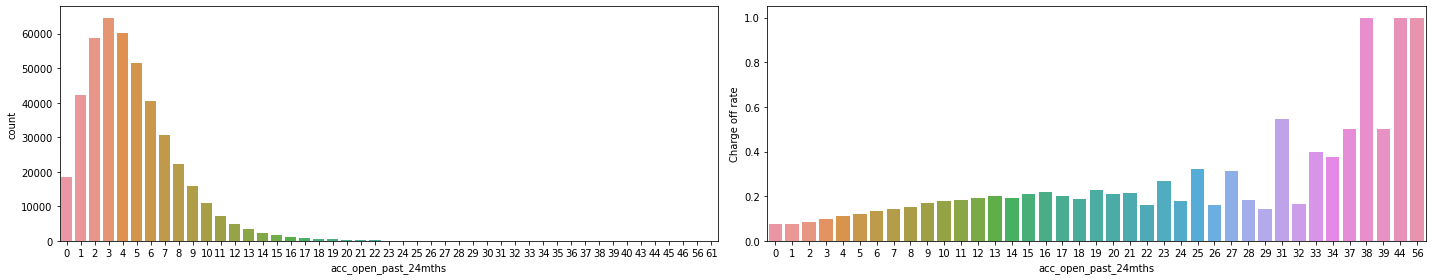

In [280]:
plot_feat("acc_open_past_24mths", cont=False)

### 6.30) `open_rv_24m`

Data Dictionary: "Number of revolving trades opened in past 24 months"

In [281]:
df["open_rv_24m"].dtype

dtype('float64')

It would make more sense for this to be an int, but there are `NaN`s & it got mad when I tried to convert the datatype.

In [282]:
df["open_rv_24m"].sample(n=5)

47717     4.0
167468    3.0
129127    2.0
221867    0.0
344480    2.0
Name: open_rv_24m, dtype: float64

In [283]:
df["open_rv_24m"].describe()

count    438964.000000
mean          2.816411
std           2.609576
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          60.000000
Name: open_rv_24m, dtype: float64

In [284]:
df.groupby("loan_status")["open_rv_24m"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387599.0,2.734587,2.553697,0.0,1.0,2.0,4.0,60.0
1,51365.0,3.433856,2.924965,0.0,1.0,3.0,5.0,36.0


In [285]:
df_class_0 = df.loc[df["loan_status"] == 0]["open_rv_24m"]
df_class_1 = df.loc[df["loan_status"] == 1]["open_rv_24m"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8429096662.0000
U-test p-value: 0.0000


Those in the Charged Off group tend to have more new revolving trades in the past 2 years.

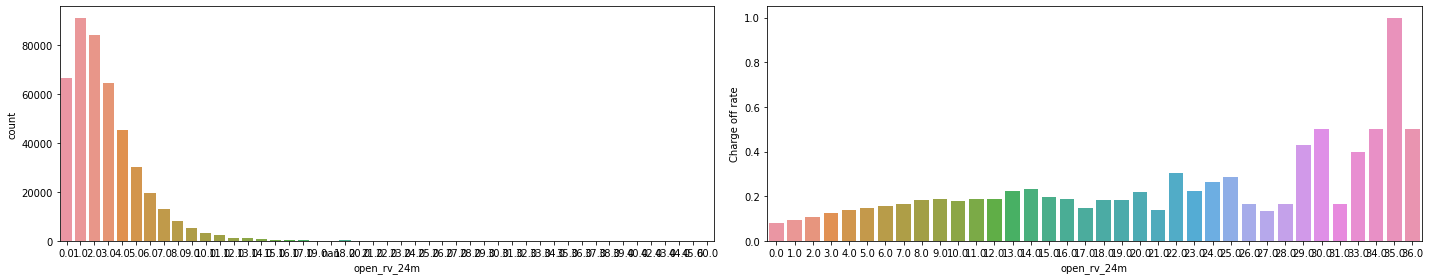

In [286]:
plot_feat("open_rv_24m", cont=False)

### 6.31) `num_rev_tl_bal_gt_0`

Data Dictionary: "Number of revolving trades with balance >0"

In [287]:
df["num_rev_tl_bal_gt_0"].dtype

dtype('int64')

In [288]:
df["num_rev_tl_bal_gt_0"].sample(n=5)

24081     8
66530     2
136194    3
310593    2
193066    3
Name: num_rev_tl_bal_gt_0, dtype: int64

In [289]:
df["num_rev_tl_bal_gt_0"].describe()

count    438991.000000
mean          5.536617
std           3.319321
min           0.000000
25%           3.000000
50%           5.000000
75%           7.000000
max          59.000000
Name: num_rev_tl_bal_gt_0, dtype: float64

In [290]:
df.groupby("loan_status")["num_rev_tl_bal_gt_0"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,5.484940,3.292179,0.0,3.0,5.0,7.0,59.0
1,51368.0,5.926569,3.492849,0.0,3.0,5.0,8.0,43.0


In [291]:
df_class_0 = df.loc[df["loan_status"] == 0]["num_rev_tl_bal_gt_0"]
df_class_1 = df.loc[df["loan_status"] == 1]["num_rev_tl_bal_gt_0"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9183798907.0000
U-test p-value: 0.0000


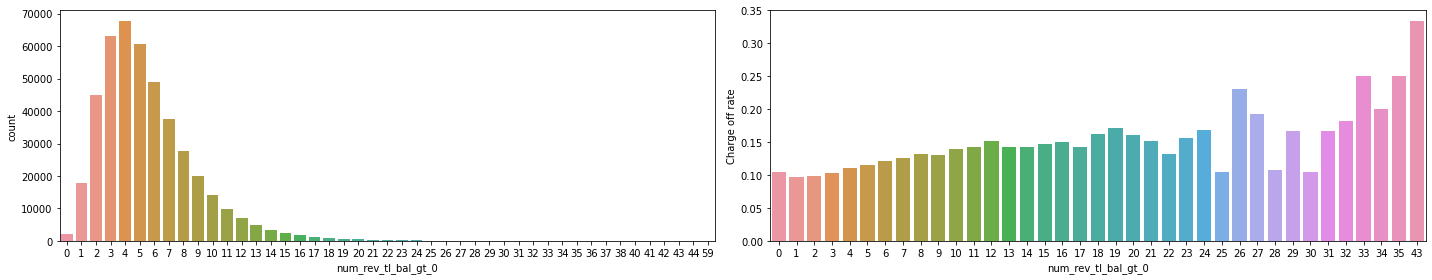

In [292]:
plot_feat("num_rev_tl_bal_gt_0", cont=False)

### 6.32) `open_act_il`

Data Dictionary: "Number of currently active installment trades"

In [293]:
df["open_act_il"].dtype

dtype('float64')

It would make more sense for this to be an int, but there are `NaN`s & it got mad when I tried to convert the datatype.

In [294]:
df["open_act_il"].sample(n=5)

343175    1.0
349555    7.0
354383    2.0
60552     3.0
6801      0.0
Name: open_act_il, dtype: float64

In [295]:
df["open_act_il"].describe()

count    438964.000000
mean          2.822894
std           3.029868
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          48.000000
Name: open_act_il, dtype: float64

In [296]:
df.groupby("loan_status")["open_act_il"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387599.0,2.815459,3.026026,0.0,1.0,2.0,3.0,46.0
1,51365.0,2.879003,3.058151,0.0,1.0,2.0,3.0,48.0


In [297]:
df_class_0 = df.loc[df["loan_status"] == 0]["open_act_il"]
df_class_1 = df.loc[df["loan_status"] == 1]["open_act_il"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9700870773.5000
U-test p-value: 0.0000


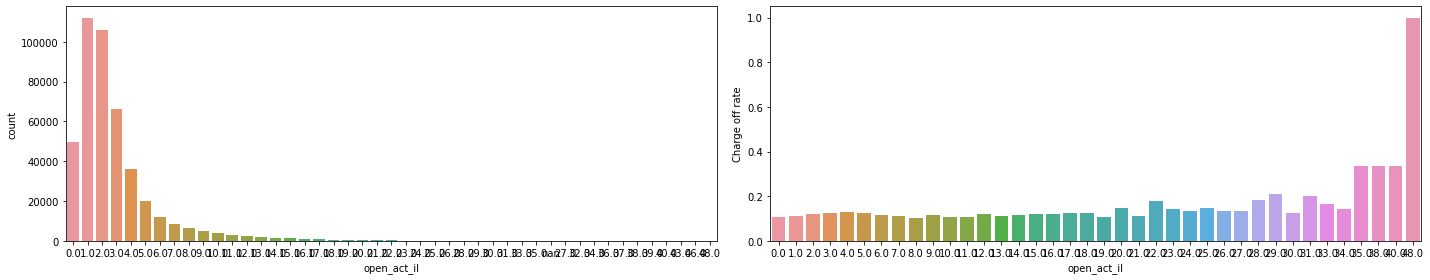

In [298]:
plot_feat("open_act_il", cont=False)

### 6.33) `num_accts_ever_120_pd`

Data Dictionary: "Number of accounts ever 120 or more days past due"

In [299]:
df["num_accts_ever_120_pd"].dtype

dtype('int64')

In [300]:
df["num_accts_ever_120_pd"].sample(n=5)

422322    0
202605    0
302399    0
397313    1
301219    3
Name: num_accts_ever_120_pd, dtype: int64

In [301]:
df["num_accts_ever_120_pd"].describe()

count    438991.000000
mean          0.537346
std           1.428550
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          51.000000
Name: num_accts_ever_120_pd, dtype: float64

In [302]:
df.groupby("loan_status")["num_accts_ever_120_pd"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,0.532071,1.426216,0.0,0.0,0.0,0.0,51.0
1,51368.0,0.577149,1.445436,0.0,0.0,0.0,1.0,31.0


In [303]:
df_class_0 = df.loc[df["loan_status"] == 0]["num_accts_ever_120_pd"]
df_class_1 = df.loc[df["loan_status"] == 1]["num_accts_ever_120_pd"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9690511919.0000
U-test p-value: 0.0000


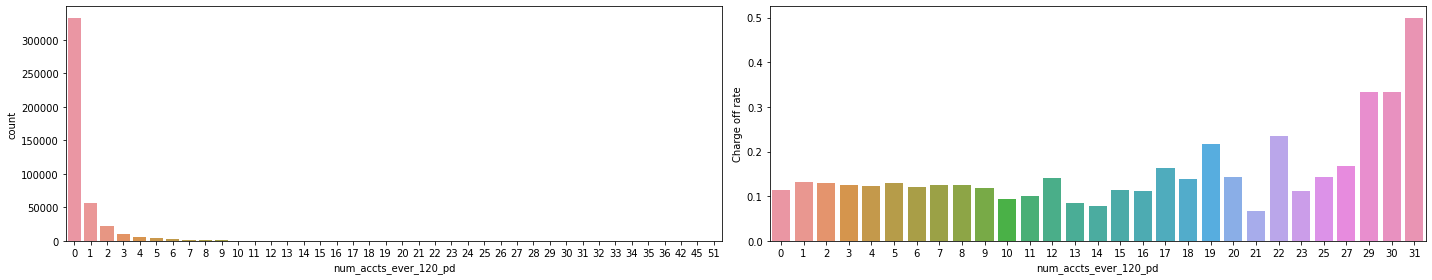

In [304]:
plot_feat("num_accts_ever_120_pd", cont=False)

### 6.34) `inq_last_12m`

Data Dictionary: "Number of credit inquiries in past 12 months"

In [305]:
df["inq_last_12m"].dtype

dtype('float64')

It would make more sense for this to be an int, but there are `NaN`s & it got mad when I tried to convert the datatype.

In [306]:
df["inq_last_12m"].sample(n=5)

383421    0.0
298295    1.0
254456    1.0
194823    1.0
230951    1.0
Name: inq_last_12m, dtype: float64

In [307]:
df["inq_last_12m"].describe()

count    438964.000000
mean          2.088128
std           2.387063
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          42.000000
Name: inq_last_12m, dtype: float64

In [308]:
df.groupby("loan_status")["inq_last_12m"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387599.0,2.020828,2.331368,0.0,0.0,1.0,3.0,42.0
1,51365.0,2.595970,2.718299,0.0,1.0,2.0,4.0,34.0


In [309]:
df_class_0 = df.loc[df["loan_status"] == 0]["inq_last_12m"]
df_class_1 = df.loc[df["loan_status"] == 1]["inq_last_12m"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8569486685.0000
U-test p-value: 0.0000


Those in the Charged Off group tend to have more credit checks on file in the past year.

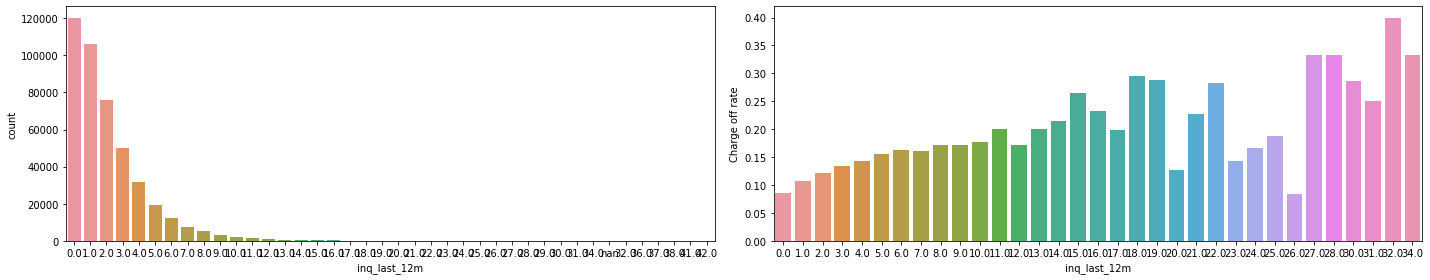

In [310]:
plot_feat("inq_last_12m", cont=False)

### 6.35) `fico_range_high`

Data Dictionary: "The upper boundary range the borrower’s FICO at loan origination belongs to"

In [311]:
df["fico_range_high"].dtype

dtype('int64')

In [312]:
df["fico_range_high"].sample(n=5)

243036    689
223281    669
261936    769
234297    664
350279    789
Name: fico_range_high, dtype: int64

In [313]:
df["fico_range_high"].describe()

count    438991.000000
mean        701.844279
std          32.929589
min         664.000000
25%         674.000000
50%         694.000000
75%         719.000000
max         850.000000
Name: fico_range_high, dtype: float64

In [314]:
df.groupby("loan_status")["fico_range_high"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,703.152494,33.456271,664.0,679.0,694.0,719.0,850.0
1,51368.0,691.972493,26.648940,664.0,674.0,684.0,704.0,850.0


In [315]:
df_class_0 = df.loc[df["loan_status"] == 0]["fico_range_high"]
df_class_1 = df.loc[df["loan_status"] == 1]["fico_range_high"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 11956564872.5000
U-test p-value: 0.0000


Those in the Fully Paid group tend to have higher FICO scores.

c:\Users\chris\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Feature: fico_range_high
Skewness: 1.2256
Kurtosis: 1.4310
Shapiro stat, p: 0.8938, 0.0000
Pearson corr w/target: -0.1091



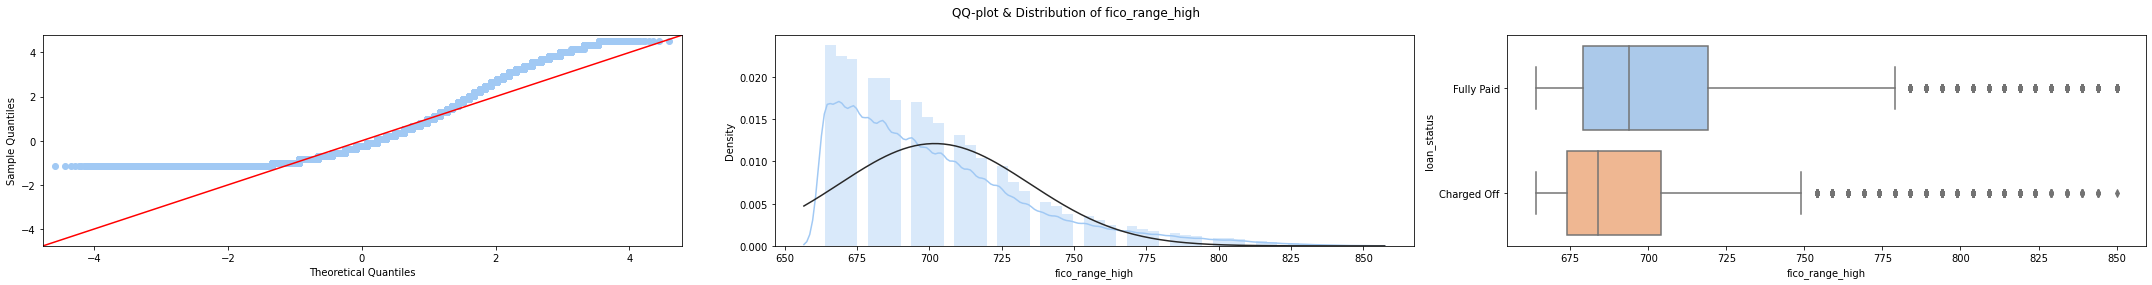

In [316]:
plot_feat("fico_range_high", cont=True)

### 6.36) `mort_acc`

Data Dictionary: "Number of mortgage accounts"

In [317]:
df["mort_acc"].dtype

dtype('int64')

In [318]:
df["mort_acc"].sample(n=5)

341204    0
137600    2
431308    2
178039    3
94781     0
Name: mort_acc, dtype: int64

In [319]:
df["mort_acc"].describe()

count    438991.000000
mean          1.486242
std           1.809667
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          94.000000
Name: mort_acc, dtype: float64

In [320]:
df.groupby("loan_status")["mort_acc"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,1.518153,1.824247,0.0,0.0,1.0,2.0,94.0
1,51368.0,1.245445,1.676155,0.0,0.0,1.0,2.0,19.0


In [321]:
df_class_0 = df.loc[df["loan_status"] == 0]["mort_acc"]
df_class_1 = df.loc[df["loan_status"] == 1]["mort_acc"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10862534329.0000
U-test p-value: 0.0000


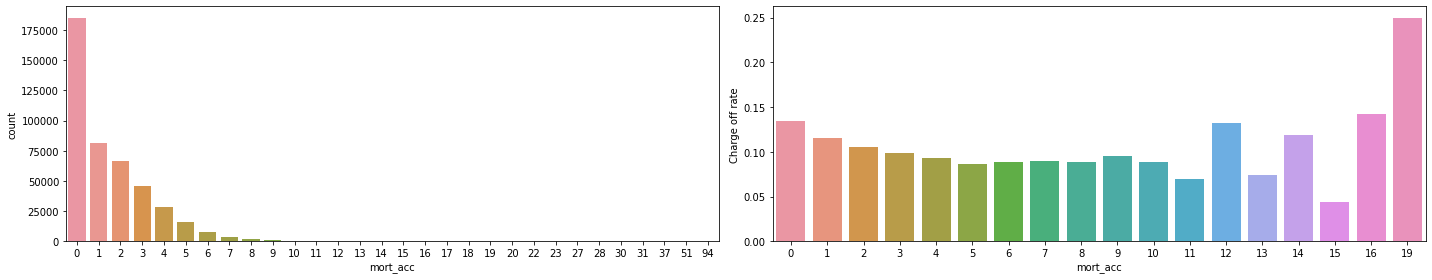

In [322]:
plot_feat("mort_acc", cont=False)

### 6.37) `delinq_2yrs`

Data Dictionary: "The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years"

In [323]:
df["delinq_2yrs"].dtype

dtype('int64')

In [324]:
df["delinq_2yrs"].sample(n=5)

64785     0
346750    0
222748    5
274822    0
317353    6
Name: delinq_2yrs, dtype: int64

In [325]:
df["delinq_2yrs"].describe()

count    438991.000000
mean          0.343415
std           0.930063
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          42.000000
Name: delinq_2yrs, dtype: float64

In [326]:
df.groupby("loan_status")["delinq_2yrs"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,0.337426,0.918664,0.0,0.0,0.0,0.0,42.0
1,51368.0,0.388608,1.010820,0.0,0.0,0.0,0.0,36.0


In [327]:
df_class_0 = df.loc[df["loan_status"] == 0]["delinq_2yrs"]
df_class_1 = df.loc[df["loan_status"] == 1]["delinq_2yrs"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9728916080.0000
U-test p-value: 0.0000


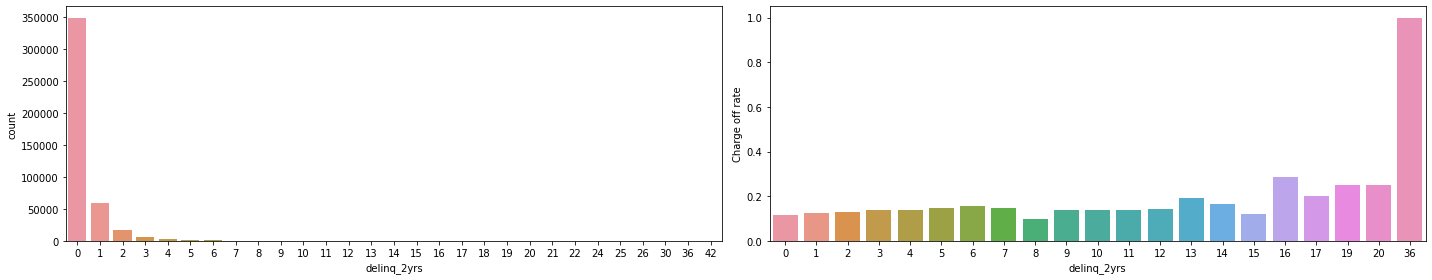

In [328]:
plot_feat("delinq_2yrs", cont=False)

### 6.38) `num_tl_90g_dpd_24m`

Data Dictionary: "Number of accounts 90 or more days past due in last 24 months"

In [329]:
df["num_tl_90g_dpd_24m"].dtype

dtype('int64')

In [330]:
df["num_tl_90g_dpd_24m"].sample(n=5)

433803    0
108862    0
385240    0
209824    0
56335     0
Name: num_tl_90g_dpd_24m, dtype: int64

In [331]:
df["num_tl_90g_dpd_24m"].describe()

count    438991.000000
mean          0.090811
std           0.537118
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          42.000000
Name: num_tl_90g_dpd_24m, dtype: float64

In [332]:
df.groupby("loan_status")["num_tl_90g_dpd_24m"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,0.088643,0.530027,0.0,0.0,0.0,0.0,42.0
1,51368.0,0.107168,0.587623,0.0,0.0,0.0,0.0,36.0


In [333]:
df_class_0 = df.loc[df["loan_status"] == 0]["num_tl_90g_dpd_24m"]
df_class_1 = df.loc[df["loan_status"] == 1]["num_tl_90g_dpd_24m"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9840970406.5000
U-test p-value: 0.0000


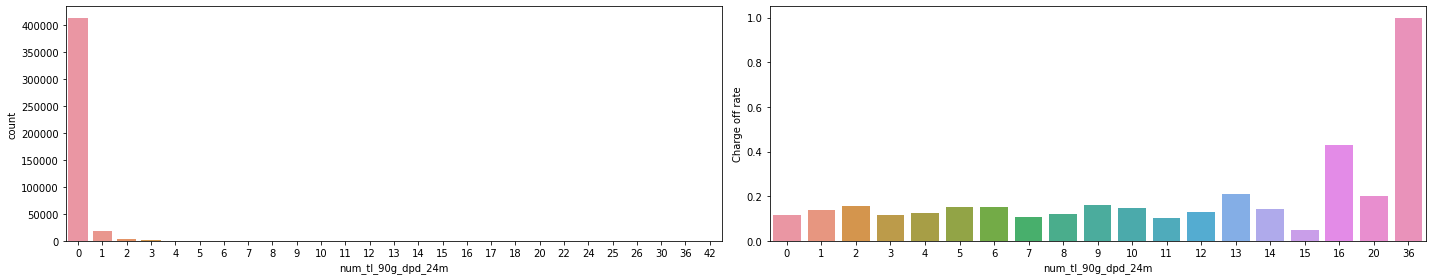

In [334]:
plot_feat("num_tl_90g_dpd_24m", cont=False)

### 6.39) `num_tl_op_past_12m`

Data Dictionary: "Number of accounts opened in past 12 months"

In [335]:
df["num_tl_op_past_12m"].dtype

dtype('int64')

In [336]:
df["num_tl_op_past_12m"].sample(n=5)

200258    2
296622    2
287866    0
129149    1
412121    4
Name: num_tl_op_past_12m, dtype: int64

In [337]:
df["num_tl_op_past_12m"].describe()

count    438991.000000
mean          2.130048
std           1.884543
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          29.000000
Name: num_tl_op_past_12m, dtype: float64

In [338]:
df.groupby("loan_status")["num_tl_op_past_12m"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,2.067026,1.846355,0.0,1.0,2.0,3.0,27.0
1,51368.0,2.605610,2.090591,0.0,1.0,2.0,4.0,29.0


In [339]:
df_class_0 = df.loc[df["loan_status"] == 0]["num_tl_op_past_12m"]
df_class_1 = df.loc[df["loan_status"] == 1]["num_tl_op_past_12m"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8369403404.5000
U-test p-value: 0.0000


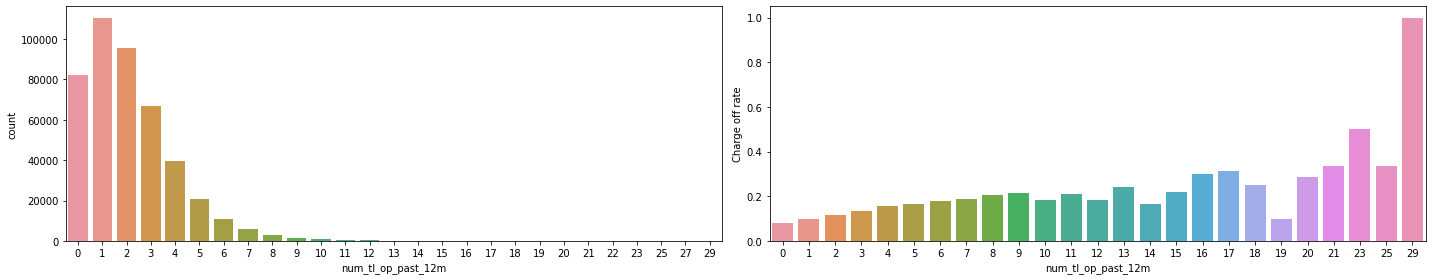

In [340]:
plot_feat("num_tl_op_past_12m", cont=False)

### 6.40) `open_il_24m`

Data Dictionary: "Number of installment accounts opened in past 24 months"

In [341]:
df["open_il_24m"].dtype

dtype('float64')

It would make more sense for this numbers to be an int.

In [342]:
df["open_il_24m"].sample(n=5)

28326     1.0
172556    2.0
193079    1.0
6219      3.0
220840    3.0
Name: open_il_24m, dtype: float64

In [343]:
df["open_il_24m"].describe()

count    438964.000000
mean          1.580271
std           1.589370
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          51.000000
Name: open_il_24m, dtype: float64

In [344]:
df.groupby("loan_status")["open_il_24m"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387599.0,1.540437,1.556894,0.0,0.0,1.0,2.0,39.0
1,51365.0,1.880853,1.787417,0.0,1.0,1.0,3.0,51.0


In [345]:
df_class_0 = df.loc[df["loan_status"] == 0]["open_il_24m"]
df_class_1 = df.loc[df["loan_status"] == 1]["open_il_24m"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8841436161.0000
U-test p-value: 0.0000


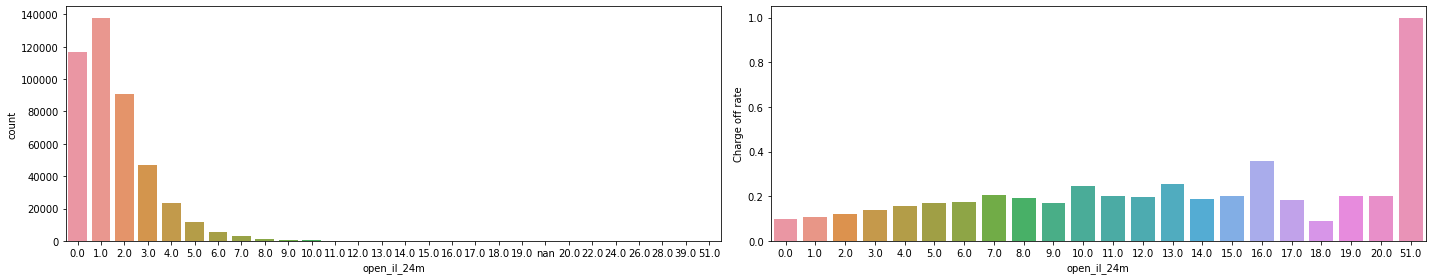

In [346]:
plot_feat("open_il_24m", cont=False)

### 6.41) `purpose`

Data Dictionary: "A category provided by the borrower for the loan request"

In [347]:
df["purpose"].dtype

dtype('O')

In [348]:
df["purpose"].sample(n=5)

421895                 HOUSE
100032           CREDIT_CARD
431106                 OTHER
299797    DEBT_CONSOLIDATION
201803      HOME_IMPROVEMENT
Name: purpose, dtype: object

In [349]:
df["purpose"].describe()

count                 438991
unique                    14
top       DEBT_CONSOLIDATION
freq                  246935
Name: purpose, dtype: object

In [350]:
df.groupby("loan_status")["purpose"].describe()

,count,unique,top,freq
loan_status,,,,
0,387623,14,DEBT_CONSOLIDATION,216124
1,51368,12,DEBT_CONSOLIDATION,30811


Most people, regardless of which group they ultimately fall into, take out loans to consolidate their debts.

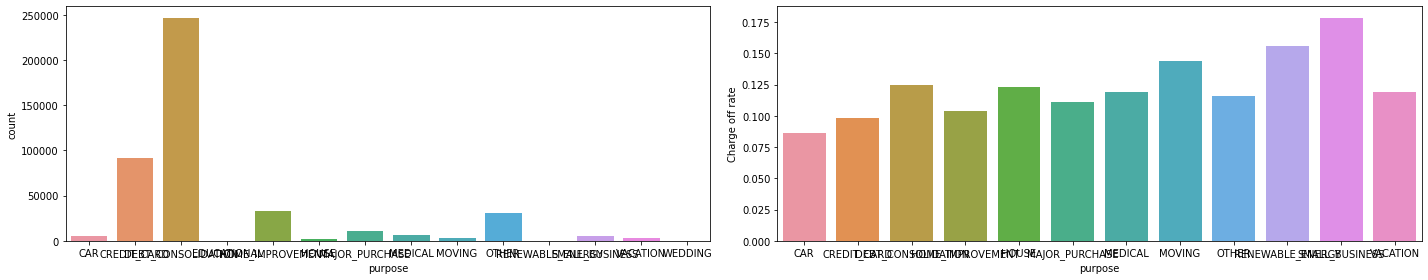

In [351]:
plot_feat("purpose", cont=False)

### 6.42) `sec_app_earliest_cr_line_mo`

Derived Feature: "Earliest credit line at time of application for the secondary applicant"

In [352]:
df["sec_app_earliest_cr_line_mo"].dtype

dtype('int64')

In [353]:
df["sec_app_earliest_cr_line_mo"].sample(n=5)

342036    9
209082    0
393321    0
201328    0
179727    0
Name: sec_app_earliest_cr_line_mo, dtype: int64

In [354]:
df["sec_app_earliest_cr_line_mo"].describe()

count    438991.000000
mean          0.303860
std           1.571181
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: sec_app_earliest_cr_line_mo, dtype: float64

In [355]:
df.groupby("loan_status")["sec_app_earliest_cr_line_mo"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,0.317587,1.604796,0.0,0.0,0.0,0.0,12.0
1,51368.0,0.200280,1.284872,0.0,0.0,0.0,0.0,12.0


In [356]:
df_class_0 = df.loc[df["loan_status"] == 0]["sec_app_earliest_cr_line_mo"]
df_class_1 = df.loc[df["loan_status"] == 1]["sec_app_earliest_cr_line_mo"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 10125446952.0000
U-test p-value: 0.0000


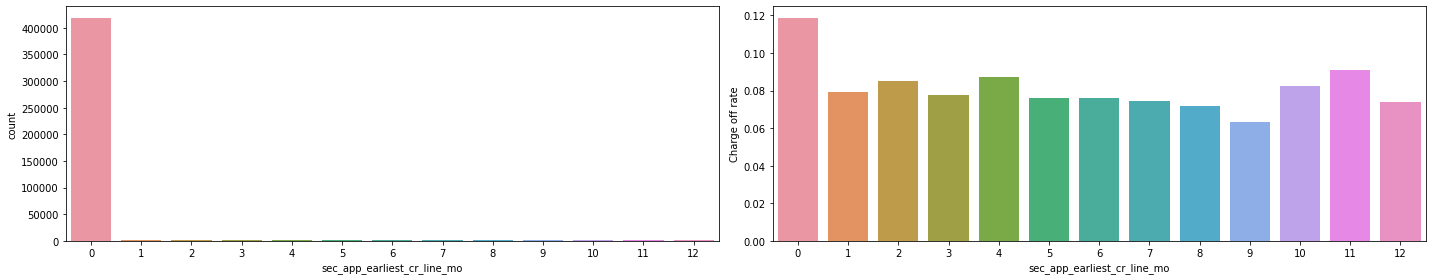

In [357]:
plot_feat("sec_app_earliest_cr_line_mo", cont=False)

### 6.43) `earliest_cr_line_mo`

Derived Feature: "The month the borrower's earliest reported credit line was opened"

In [358]:
df["earliest_cr_line_mo"].dtype

dtype('int64')

In [359]:
df["earliest_cr_line_mo"].sample(n=5)

384957     2
314401     4
68932      9
312342    12
167674     4
Name: earliest_cr_line_mo, dtype: int64

In [360]:
df["earliest_cr_line_mo"].describe()

count    438991.000000
mean          6.734004
std           3.368598
min           1.000000
25%           4.000000
50%           7.000000
75%          10.000000
max          12.000000
Name: earliest_cr_line_mo, dtype: float64

In [361]:
df.groupby("loan_status")["earliest_cr_line_mo"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,6.734897,3.367266,1.0,4.0,7.0,10.0,12.0
1,51368.0,6.727262,3.378663,1.0,4.0,7.0,10.0,12.0


In [362]:
df_class_0 = df.loc[df["loan_status"] == 0]["earliest_cr_line_mo"]
df_class_1 = df.loc[df["loan_status"] == 1]["earliest_cr_line_mo"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9966693205.5000
U-test p-value: 0.6829


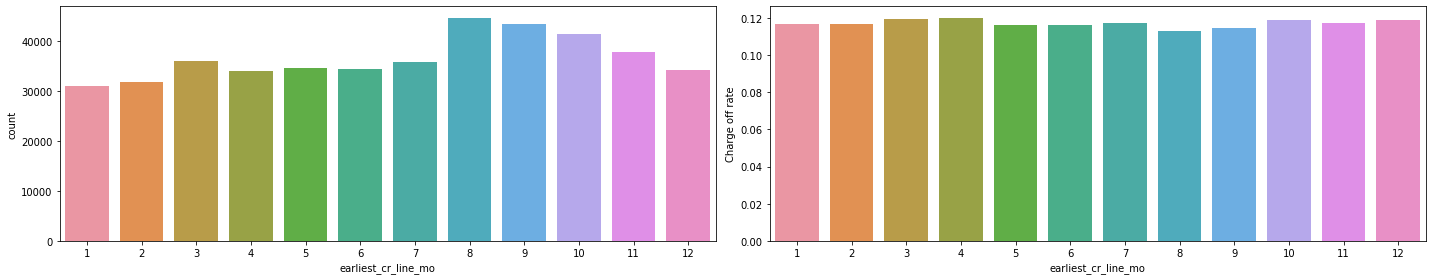

In [363]:
plot_feat("earliest_cr_line_mo", cont=False)

### 6.44) `emp_length`

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years"

In [364]:
df["emp_length"].dtype

dtype('float64')

It would make more sense for thi to be an int.

In [365]:
df["emp_length"].sample(n=5)

280553    3.0
59712     1.0
227102    5.0
348686    8.0
14640     0.0
Name: emp_length, dtype: float64

In [366]:
df["emp_length"].describe()

count    408978.000000
mean          6.295987
std           4.159363
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          11.000000
Name: emp_length, dtype: float64

In [367]:
df.groupby("loan_status")["emp_length"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,362231.0,6.322805,4.160016,0.0,2.0,6.0,11.0,11.0
1,46747.0,6.088177,4.148473,0.0,2.0,6.0,11.0,11.0


In [368]:
df_class_0 = df.loc[df["loan_status"] == 0]["emp_length"]
df_class_1 = df.loc[df["loan_status"] == 1]["emp_length"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8734541032.5000
U-test p-value: 0.0000


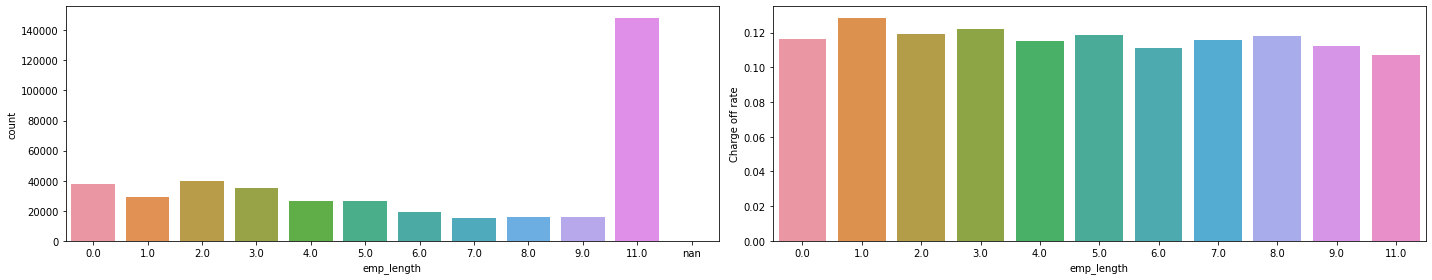

In [369]:
plot_feat("emp_length", cont=False)

### 6.45) `pub_rec_bankruptcies`

Data Dictionary: "Number of public record bankruptcies"

In [370]:
df["pub_rec_bankruptcies"].dtype

dtype('int64')

In [371]:
df["pub_rec_bankruptcies"].sample(n=5)

319367    0
349178    0
289916    0
380485    0
190       0
Name: pub_rec_bankruptcies, dtype: int64

In [372]:
df["pub_rec_bankruptcies"].describe()

count    438991.000000
mean          0.139611
std           0.384764
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: pub_rec_bankruptcies, dtype: float64

In [373]:
df.groupby("loan_status")["pub_rec_bankruptcies"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,0.135400,0.378739,0.0,0.0,0.0,0.0,8.0
1,51368.0,0.171391,0.426164,0.0,0.0,0.0,0.0,8.0


In [374]:
df_class_0 = df.loc[df["loan_status"] == 0]["pub_rec_bankruptcies"]
df_class_1 = df.loc[df["loan_status"] == 1]["pub_rec_bankruptcies"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9643613950.0000
U-test p-value: 0.0000


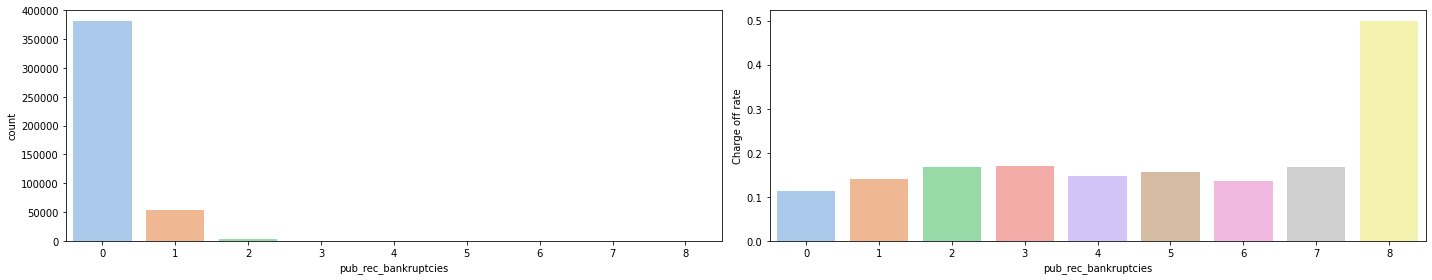

In [375]:
plot_feat("pub_rec_bankruptcies", cont=False)

### 6.46) `inq_last_6mths`

Data Dictionary: "The number of inquiries in past 6 months (excluding auto and mortgage inquiries)"

In [376]:
df["inq_last_6mths"].dtype

dtype('float64')

It would make more sense for this to be an int.

In [377]:
df["inq_last_6mths"] = df["inq_last_6mths"].astype("int")

In [378]:
df["inq_last_6mths"].sample(n=5)

197542    1
297599    1
114120    1
368167    0
377979    0
Name: inq_last_6mths, dtype: int32

In [379]:
df["inq_last_6mths"].describe()

count    438991.000000
mean          0.533523
std           0.830201
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: inq_last_6mths, dtype: float64

In [380]:
df.groupby("loan_status")["inq_last_6mths"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,0.509144,0.807232,0.0,0.0,0.0,1.0,5.0
1,51368.0,0.717489,0.966814,0.0,0.0,0.0,1.0,5.0


In [381]:
df_class_0 = df.loc[df["loan_status"] == 0]["inq_last_6mths"]
df_class_1 = df.loc[df["loan_status"] == 1]["inq_last_6mths"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 8804312116.5000
U-test p-value: 0.0000


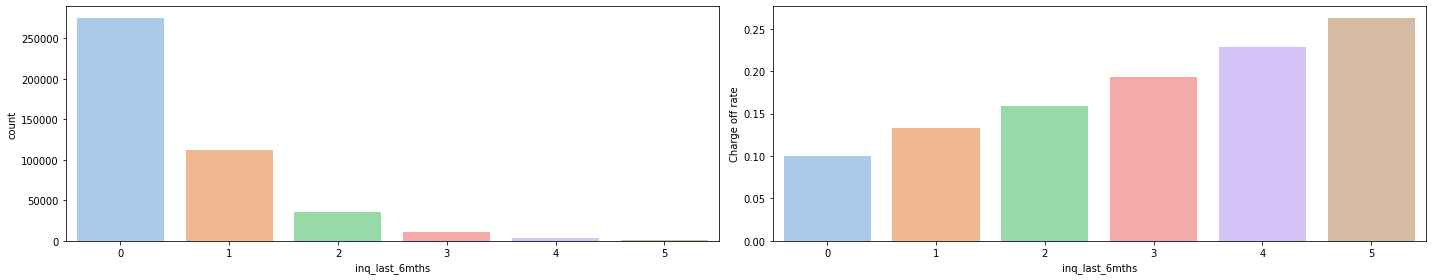

In [382]:
plot_feat("inq_last_6mths", cont=False)

The chances of a loan being Charged Off are directly proportional to the number of credit checks that an applicant has have in the previous six months.

### 6.47) `home_ownership`

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"

In [383]:
df["home_ownership"].dtype

dtype('O')

In [384]:
df["home_ownership"].sample(n=5)

421862    MORTGAGE
304980    MORTGAGE
351316        RENT
195126        RENT
180431    MORTGAGE
Name: home_ownership, dtype: object

In [385]:
df["home_ownership"].describe()

count       438991
unique           5
top       MORTGAGE
freq        214298
Name: home_ownership, dtype: object

In [386]:
df.groupby("loan_status")["home_ownership"].describe()

,count,unique,top,freq
loan_status,,,,
0,387623,5,MORTGAGE,192874
1,51368,4,RENT,23653


Those in the Charged Off group tend to be renters while those in the Fully Paid group tend to be either home owners or those who are paying off a home.

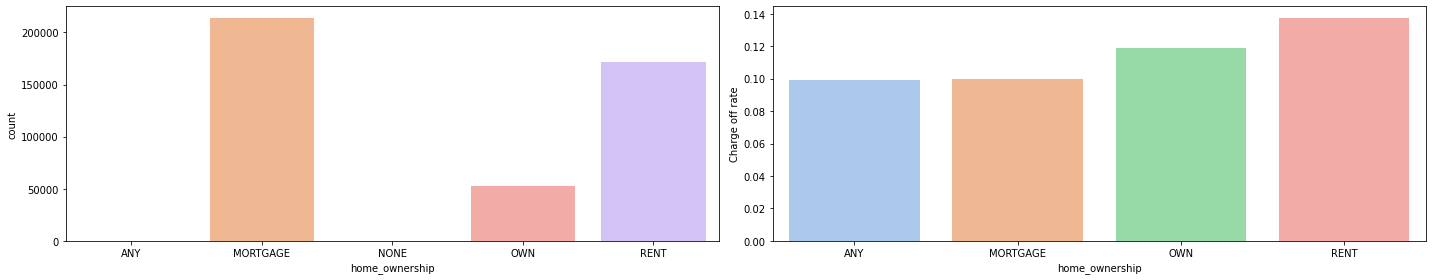

In [387]:
plot_feat("home_ownership", cont=False)

### 6.48) `app_qr`

Derived Feature: "Quarter of the year in which the application was submitted"

In [388]:
df["app_qr"].dtype

dtype('O')

In [389]:
df["app_qr"].sample(n=5)

286946    Q2
242778    Q1
328800    Q3
171550    Q4
179046    Q4
Name: app_qr, dtype: object

In [390]:
df["app_qr"].describe()

count     438991
unique         4
top           Q1
freq      115332
Name: app_qr, dtype: object

In [391]:
df.groupby("loan_status")["app_qr"].describe()

,count,unique,top,freq
loan_status,,,,
0,387623,4,Q4,101517
1,51368,4,Q1,16480


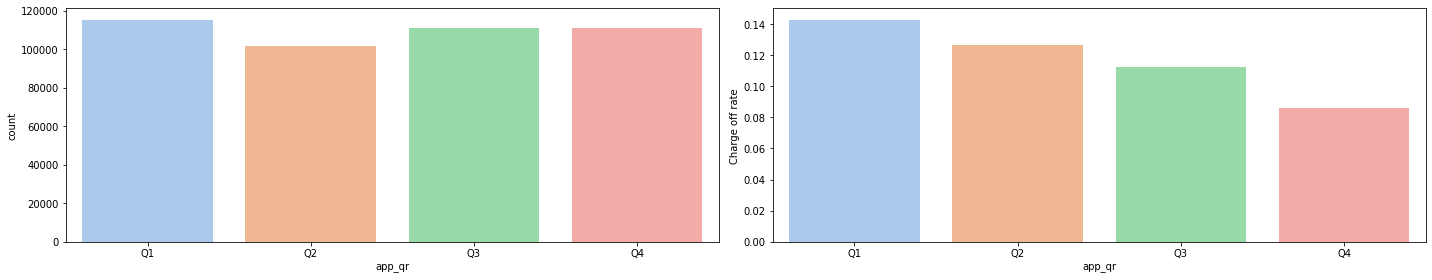

In [392]:
plot_feat("app_qr", cont=False)

Loans applications filed later in the year have more of a chance, albeit only *slightly*, of being Fully Paid.

### 6.49) `application_type`

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers"

In [393]:
df["application_type"].dtype

dtype('O')

In [394]:
df["application_type"].sample(n=5)

5695      INDIVIDUAL
381414    INDIVIDUAL
73719     INDIVIDUAL
268318    INDIVIDUAL
69483     INDIVIDUAL
Name: application_type, dtype: object

In [395]:
df["application_type"].describe()

count         438991
unique             2
top       INDIVIDUAL
freq          413182
Name: application_type, dtype: object

In [396]:
df.groupby("loan_status")["application_type"].describe()

,count,unique,top,freq
loan_status,,,,
0,387623,2,INDIVIDUAL,364146
1,51368,2,INDIVIDUAL,49036


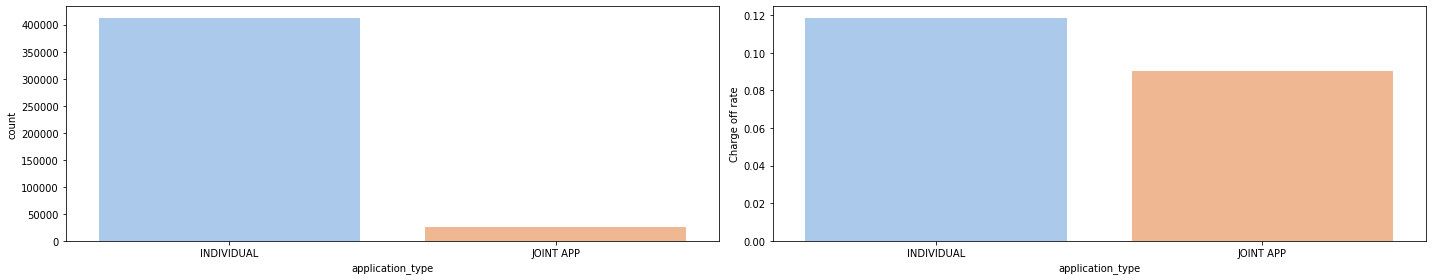

In [397]:
plot_feat("application_type", cont=False)

Joint applications are safer than individual applications.

### 6.50) `term`

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60"

In [398]:
df["term"].dtype

dtype('int32')

In [399]:
df["term"].sample(n=5)

257617    36
434954    60
100227    36
393685    60
203618    36
Name: term, dtype: int32

In [400]:
df["term"].describe()

count    438991.000000
mean         42.383092
std          10.604273
min          36.000000
25%          36.000000
50%          36.000000
75%          60.000000
max          60.000000
Name: term, dtype: float64

In [401]:
df.groupby("loan_status")["term"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,42.180314,10.494358,36.0,36.0,36.0,60.0,60.0
1,51368.0,43.913253,11.282774,36.0,36.0,36.0,60.0,60.0


In [402]:
df_class_0 = df.loc[df["loan_status"] == 0]["term"]
df_class_1 = df.loc[df["loan_status"] == 1]["term"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 9236849268.5000
U-test p-value: 0.0000


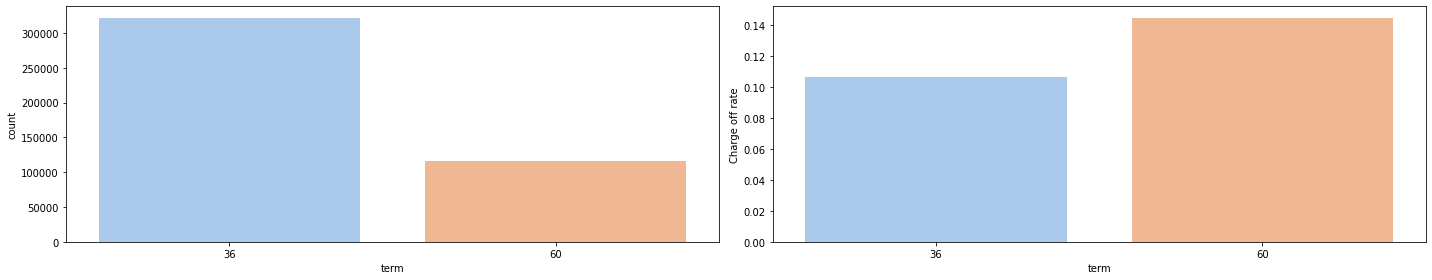

In [403]:
plot_feat("term", cont=False)

Loans with longer terms are charged off at a higher rate.

### 6.51) `app_yr`

Derived Feature: "The year in which the application was submitted"

In [404]:
df["app_yr"].dtype

dtype('int32')

In [405]:
df["app_yr"].sample(n=5)

184749    2016
334758    2017
358353    2017
363558    2017
237591    2017
Name: app_yr, dtype: int32

In [406]:
df["app_yr"].describe()

count    438991.000000
mean       2016.505222
std           0.499973
min        2016.000000
25%        2016.000000
50%        2017.000000
75%        2017.000000
max        2017.000000
Name: app_yr, dtype: float64

In [407]:
df.groupby("loan_status")["app_yr"].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,387623.0,2016.526377,0.499304,2016.0,2016.0,2017.0,2017.0,2017.0
1,51368.0,2016.345585,0.475563,2016.0,2016.0,2016.0,2017.0,2017.0


In [408]:
df_class_0 = df.loc[df["loan_status"] == 0]["app_yr"]
df_class_1 = df.loc[df["loan_status"] == 1]["app_yr"]

mwu_t, mwu_p = scp.mannwhitneyu(x=df_class_0, y=df_class_1, method="asymptotic", nan_policy="omit")

print(f"U-test stat: {mwu_t:.4f}")
print(f"U-test p-value: {mwu_p:.4f}")

U-test stat: 11755628008.0000
U-test p-value: 0.0000


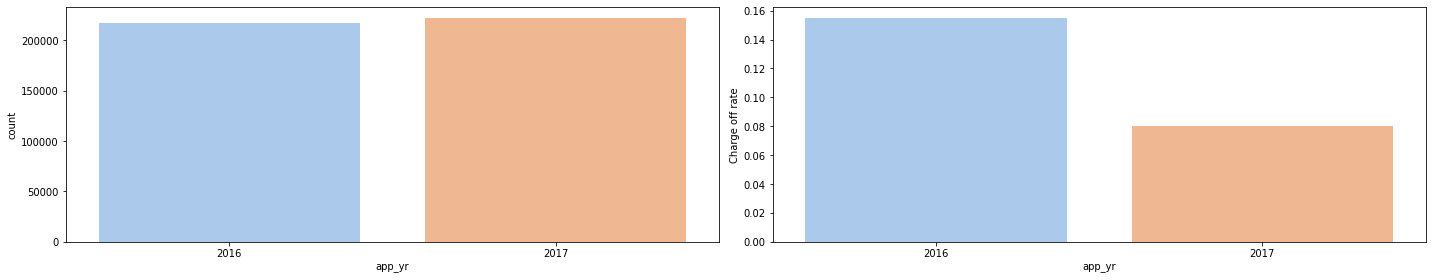

In [409]:
plot_feat("app_yr", cont=False)

Loan applications filed in 2017 are charged off nearly half as much as those in 2016.

We only got into univariate & bivariate descriptions of the features here, but we could eventually extend our adventures to multivariate statistics. Right now, we've only seen how a feature can vary against the target variable. Multivariate statistics can quickly become hairy (which is why I'd abstain if ease of interpretability is a priority), but it would allow us to determine if various combinations of features were more or less informative than themselves in isolation (e.g., would credit score + interest rate yield more information than either on their own?).

## 7) Modeling

### 7.1) Encoding categortical features

In [410]:
cat_feat = df.select_dtypes("object").columns
df = pd.get_dummies(df, columns=cat_feat, drop_first=True)

### 7.2) Train/test split

In [411]:
y = df["loan_status"]
X = df.copy().drop("loan_status", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=123)

In [412]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(351192, 116)
(351192,)
(87799, 116)
(87799,)


Since we're about to construct some models, let's turn back to the imbalance in the distribution of our target feature. There are a number of ways that we could go about dealing with this (many of which I've tried before settling on this), but we'll choose to upweight the minority class such that it'll even out with the majority.

In [413]:
print(f"Number of 0 class: {X_train[y_train == 0].shape[0]}")
print(f"Number of 1 class: {X_train[y_train == 1].shape[0]}")
print()
print(f"Majority (Class 0) / Minority (Class 1): {X_train[y_train == 0].shape[0] / X_train[y_train == 1].shape[0]:.4f}")

Number of 0 class: 310098
Number of 1 class: 41094

Majority (Class 0) / Minority (Class 1): 7.5461


### 7.3) Linear dependence of Charge Off on predictors

In [414]:
linear_dep = pd.DataFrame()

In [415]:
for col in X.columns:
    linear_dep.loc[col, "pearson_r"] = X[col].corr(y)

linear_dep["abs_pearson_r"] = abs(linear_dep["pearson_r"])

In [416]:
for col in X.columns:
    mask = X[col].notnull()
    (linear_dep.loc[col, "F_stat"], linear_dep.loc[col, "p_value"]) = f_classif(pd.DataFrame(X.loc[mask, col]), y.loc[mask])

In [417]:
linear_dep.sort_values("abs_pearson_r", ascending=False, inplace=True)
linear_dep.drop("abs_pearson_r", axis=1, inplace=True)

In [418]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={"index": "variable"}, inplace=True)

In [419]:
linear_dep.head(n=35)

,variable,pearson_r,F_stat,p_value
0,int_rate,0.209082,20067.849070,0.000000e+00
1,app_yr,-0.116233,-438989.000000,NaN
2,fico_range_high,-0.109132,5291.271247,0.000000e+00
3,acc_open_past_24mths,0.100145,4447.209308,0.000000e+00
4,num_tl_op_past_12m,0.091864,3736.122319,0.000000e+00
5,open_rv_24m,0.086133,3280.976223,0.000000e+00
6,inq_last_6mths,0.080667,2875.292287,0.000000e+00
7,inq_last_12m,0.077448,2648.835176,0.000000e+00
8,open_il_24m,0.068846,2090.507704,0.000000e+00
9,all_util,0.065132,1869.875197,0.000000e+00


It seems that the features that are most strongly associated with `loan_status` have to do with how many credit checks you've had recently, your credit score (`fico_range_high`), and the interest rate (`int_rate`) that would be applied to your loan should it be funded. Going further down the list, we see things like `home_ownership`, the number of `term`s you have to pay back your loan, and your debt to income ratio (`dti`). I would say that most of these features make intuitive sense when it comes to evaluating an application for a loan.

### 7.4) Training

For modeling, we'll utilize pipelines to package a few different things together. Pipelines are modular structures that contain multiple subunits that perform individual functions prior to passing the data to the next unit. This creates an end-to-end product that can ingest the data, process it, and pass it to a model for fitting & optimization. Generally speaking, our pipelines will adhere to the following structure:

    1) An imputer, which will fill in `NaN` values with the mean of the feature.
    2) A filter that will discard any constant features.
    3) A feature selector that'll utilize an F test, which we implemented above, that'll select the top 30 features.
    4) If needed, a feature scaler (Tree-based methods don't require scaling).
    5) A randomized grid search that'll optimize a set of selected parameters for a model.

We're using the `VarianceThreshold` as a filter prior to the `SelectKBest` step because we'll have some constant features that yield useless results from the `f_classif` test. Additionally, we're decreasing the feature space in the first place because a lot of the features exhibit weak correlations with the target & it'll lighten the computaional load on my machine.

### 7.4.1) Logistic Regression w/SGD training

We're starting with logistic regression because it's a solid choice for an off the shelf classifier. It's usually very easy to interpret while also being one of the least computationally taxing types of models.

We're choosing the F-0.5 score as our scoring metric because it shares a lot of characteristics with the F-1 score, which is a solid choice for balancing your priorities between precision & recall. The F-0.5 score differs in that it slightly favors precision, which should have the effect of minimizing false negatives. This characteristic is desirable because we'd rather miss out on a few good investments (i.e., false positives) rather than invest in bad loans (i.e., false negatives). 

In [420]:
pipe_sgdlr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean", copy=False)),
    ("filter", VarianceThreshold()),
    ("selector", SelectKBest(score_func=f_classif, k=30)),
    ("scaler", StandardScaler(copy=False)),
    ("model", SGDClassifier(loss="log", max_iter=1000, tol=1e-3, random_state=123, warm_start=True, class_weight={0: 1, 1: 7.5461}))
])

p_dist = {
    "model__alpha": scp.loguniform(0.0001, 10),
    "model__penalty": ["l1", "l2"]
}

sgdlr_cv = RandomizedSearchCV(
    estimator=pipe_sgdlr,
    param_distributions=p_dist,
    cv=10,
    n_iter=10,
    scoring=make_scorer(fbeta_score, beta=0.5),
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=123
)

sgdlr_cv = sgdlr_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [421]:
y_pred = sgdlr_cv.predict(X_train)

print("Training:\n" + \
    classification_report(
        y_true=y_train,
        y_pred=y_pred,
        target_names=["Fully Paid", "Charged Off"]
    )
)

Training:
              precision    recall  f1-score   support

  Fully Paid       0.94      0.68      0.79    310098
 Charged Off       0.21      0.65      0.32     41094

    accuracy                           0.67    351192
   macro avg       0.57      0.66      0.55    351192
weighted avg       0.85      0.67      0.73    351192



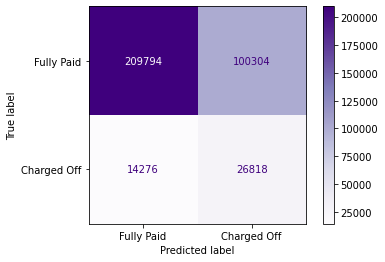

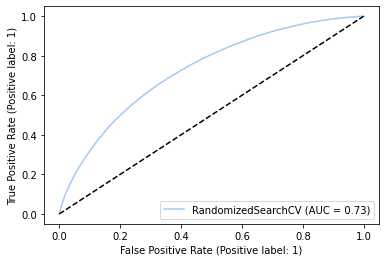

In [422]:
disp = ConfusionMatrixDisplay.from_estimator(
    sgdlr_cv,
    X_train,
    y_train, 
    cmap="Purples",
    values_format="d", 
    display_labels=["Fully Paid", "Charged Off"]
)

disp = RocCurveDisplay.from_estimator(sgdlr_cv, X_train, y_train)
plt.plot([0, 1], [0, 1], "k--")

It's good to see that our model isn't afraid to predict both classes. With imbalanced binary classification problems, a classifier can learn to solely predict the majority class if care isn't taken to adjust class numbers/weights or a poor choice of scoring metric (e.g., plain old accuracy) is used during training. After training, it seems that we've developed a somewhat competent classifier. It is far from a perfect specimen, but it would be substantially better at identifying charged off loans than a random guess.

### 7.4.2) XGBoost

Our second choice of model is XGBoost, which is considered, by some, as the "king" of tabular data modeling.

We're choosing the F-0.5 score as our scoring metric because it shares a lot of characteristics with the F-1 score, which is a solid choice for balancing your priorities between precision & recall. The F-0.5 score differs in that it slightly favors precision, which should have the effect of minimizing false negatives. This characteristic is desirable because we'd rather miss out on a few good investments (i.e., false positives) rather than invest in bad loans (i.e., false negatives). 

In [423]:
pipe_xgb = Pipeline([
    ("imputer", SimpleImputer(strategy="mean", copy=False)),
    ("filter", VarianceThreshold()),
    ("selector", SelectKBest(score_func=f_classif, k=30)),
    ("model", XGBClassifier(use_label_encoder=False, scale_pos_weight=7.5461))
])

p_dist = {
    "model__n_estimators": scp.randint(10, 500),
    "model__max_depth": scp.randint(1, 10),
    "model__learning_rate": scp.uniform(0, 1)
}

xgb_cv = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=p_dist,
    cv=10,
    n_iter=10,
    scoring=make_scorer(fbeta_score, beta=2.0),
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=123
)

xgb_cv = xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[06:27:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [424]:
y_pred = xgb_cv.predict(X_train)

print("Training:\n" + \
    classification_report(
        y_true=y_train,
        y_pred=y_pred,
        target_names=["Fully Paid", "Charged Off"]
    )
)

Training:
              precision    recall  f1-score   support

  Fully Paid       0.94      0.66      0.77    310098
 Charged Off       0.21      0.69      0.32     41094

    accuracy                           0.66    351192
   macro avg       0.58      0.67      0.55    351192
weighted avg       0.86      0.66      0.72    351192



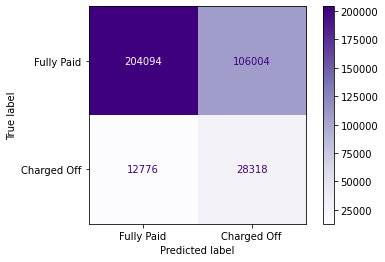

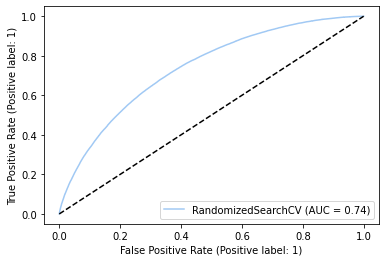

In [425]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_cv,
    X_train,
    y_train, 
    cmap="Purples",
    values_format="d", 
    display_labels=["Fully Paid", "Charged Off"]
)

disp = RocCurveDisplay.from_estimator(xgb_cv, X_train, y_train)
plt.plot([0, 1], [0, 1], "k--")

Like our logistic regression model, this one avoided the pitfall of simply predicting the majority class. Looking at the metrics, this model performs very similarly to the previous one.

## 8) Conclusion

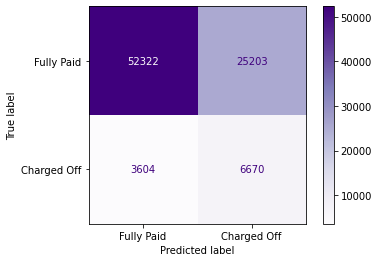

In [426]:
disp = ConfusionMatrixDisplay.from_estimator(
    sgdlr_cv,
    X_test,
    y_test, 
    cmap="Purples",
    values_format="d", 
    display_labels=["Fully Paid", "Charged Off"]
)

In [427]:
y_pred = sgdlr_cv.predict(X_test)

print("Test:\n" + \
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
        target_names=["Fully Paid", "Charged Off"]
    )
)

Test:
              precision    recall  f1-score   support

  Fully Paid       0.94      0.67      0.78     77525
 Charged Off       0.21      0.65      0.32     10274

    accuracy                           0.67     87799
   macro avg       0.57      0.66      0.55     87799
weighted avg       0.85      0.67      0.73     87799



The SGD logistic regression model appears to generalize well to the test data.

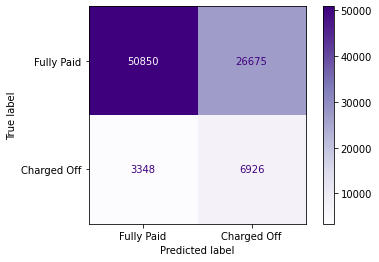

In [428]:
disp = ConfusionMatrixDisplay.from_estimator(
    xgb_cv,
    X_test,
    y_test, 
    cmap="Purples",
    values_format="d", 
    display_labels=["Fully Paid", "Charged Off"]
)

In [429]:
y_pred = xgb_cv.predict(X_test)

print("Test:\n" + \
    classification_report(
        y_true=y_test,
        y_pred=y_pred,
        target_names=["Fully Paid", "Charged Off"]
    )
)

Test:
              precision    recall  f1-score   support

  Fully Paid       0.94      0.66      0.77     77525
 Charged Off       0.21      0.67      0.32     10274

    accuracy                           0.66     87799
   macro avg       0.57      0.67      0.54     87799
weighted avg       0.85      0.66      0.72     87799



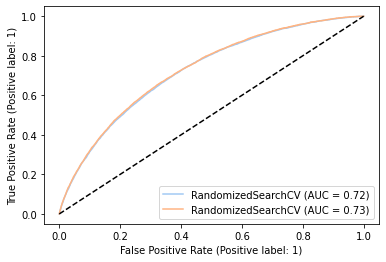

In [430]:
disp = RocCurveDisplay.from_estimator(sgdlr_cv, X_test, y_test)
RocCurveDisplay.from_estimator(xgb_cv, X_test, y_test, ax=disp.ax_)
plt.plot([0, 1], [0, 1], "k--")

In [431]:
sdglr_y_hat = sgdlr_cv.predict_proba(X_test)[:, 1]
xgb_y_hat = xgb_cv.predict_proba(X_test)[:, 1]

print("AUROC Scores")
print(f"SGDLR: {roc_auc_score(y_test, sdglr_y_hat):.4f}")
print(f"XGBoost: {roc_auc_score(y_test, xgb_y_hat):.4f}")

AUROC Scores
SGDLR: 0.7239
XGBoost: 0.7272


Unfortunately, although we tried to minimize it, there are still some false negatives, which could lead us to invest in a bad loan & lose money. That being said, both models would perform much better than a random guess, so either would be a good tool for a potential investor to thin the field prior to making their own final determinations on which loan(s) to ultimately invest in. In terms of performance, I would say that the relatively simple logistic regression model would be a much better choice. It is simpler to understand & explain (i.e., if you have to make a case to a supervisor/board or something) and it takes significantly less time & resources to train & implement the model.